# VGGIsh Multi Seed Validation
#### 5 Random (but reproducible) seeds are selected for 5 different runs of train/test
#### Models have been optimised and verified on validation sets thoroughly, running a final train/test evaluation here
#### The setup:

- 4 fold StratifiedGroupKFold for stratification and ensuring each cat_id group only appears in one set at a time
- Final scores averaged over the 4 folds
- For each seed run we will explore the cat_id predictions through majority voting
- For each run we will explore the potential impact of gender
- Includes visualisations & analysis

The dataset is highly unbalanced.

In [92]:
# Standard imports
import numpy as np
import pandas as pd
import random
from datetime import datetime
from collections import Counter

# Sklearn imports
from sklearn.model_selection import train_test_split, GroupShuffleSplit, GroupKFold, StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.inspection import permutation_importance

# Imbalanced-learn import
from imblearn.over_sampling import SMOTE

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, concatenate
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax, AdamW
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.utils import to_categorical
from keras.regularizers import l1, l2, L1L2

# Optuna import
import optuna

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import statistical tests
from scipy.stats import levene

from IPython.display import display
import time

In [93]:
# Track running time (including analysis)
start_time = time.time()

In [94]:
# Set an initial seed for reproducibility
np.random.seed(42)  

# Generate a list of 5 random seeds
random_seeds = np.random.randint(0, 10000, size=5)
print("Random Seeds:", random_seeds)

Random Seeds: [7270  860 5390 5191 5734]


#### TOTAL RESULTS ACROSS SEED INITIATION

In [95]:
# Lists to collect statistics across all CVs
all_losses, all_accuracies, all_precisions, all_recalls, all_f1 = [], [], [], [], []
average_fold_losses, average_fold_accuracies, average_fold_precisions, average_fold_recalls, average_fold_f1 = [], [], [], [], []
all_majority_vote_accuracies, all_majority_vote_details, all_class_stats, all_gender_stats  = [], [], [], []

# training accuracies
all_best_training_acc = []
total_training_acc = []

## Define Functions

In [96]:
def check_initial_group_split(groups_train, groups_test):
    """
    Check if any group is present in both the train and test sets.

    Parameters:
    - groups_train: Array of group identifiers for the train set
    - groups_test: Array of group identifiers for the test set

    Returns:
    - Prints out any groups found in both sets and the count of such groups
    """
    train_groups = set(groups_train)
    test_groups = set(groups_test)
    common_groups = train_groups.intersection(test_groups)

    if common_groups:
        print(f"Warning: Found {len(common_groups)} common groups in both train/validation and test sets: {common_groups}")
    else:
        print("No common groups found between train and test sets.")


In [97]:
# Function to perform the swaps based on cat_id, ensuring swaps within the same age_group
def swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids):
    for cat_id in specific_cat_ids:
        # Check if the specific cat_id is not in the training set
        if cat_id not in dataframe.iloc[train_val_idx]['cat_id'].values:
            # Get the age_group of this cat_id
            age_group = dataframe[dataframe['cat_id'] == cat_id]['age_group'].iloc[0]
                
            # Find a different cat_id within the same age_group in the train set that is not in the test set
            other_cat_ids_in_age_group = dataframe[(dataframe['age_group'] == age_group) & 
                                                   (dataframe['cat_id'] != cat_id) &
                                                   (~dataframe['cat_id'].isin(dataframe.iloc[test_idx]['cat_id']))]['cat_id'].unique()
            
            # Choose one other cat_id for swapping
            if len(other_cat_ids_in_age_group) > 0:
                other_cat_id = np.random.choice(other_cat_ids_in_age_group)

                # Find all instances of the other_cat_id in the train set
                other_cat_id_train_val_indices = train_val_idx[dataframe.iloc[train_val_idx]['cat_id'] == other_cat_id]
                
                # Find all instances of the specific cat_id in the test set
                cat_id_test_indices = test_idx[dataframe.iloc[test_idx]['cat_id'] == cat_id]
                
                # Swap the indices
                train_val_idx = np.setdiff1d(train_val_idx, other_cat_id_train_val_indices, assume_unique=True)
                test_idx = np.setdiff1d(test_idx, cat_id_test_indices, assume_unique=True)

                train_val_idx = np.concatenate((train_val_idx, cat_id_test_indices))
                test_idx = np.concatenate((test_idx, other_cat_id_train_val_indices))
            else:
                print(f"No alternative cat_id found in the same age_group as {cat_id} for swapping.")
                
    return train_val_idx, test_idx

In [98]:
# Function to identify differences in groups
def find_group_differences(original, new):
    # Convert numpy arrays to sets for easy difference computation
    original_set = set(original)
    new_set = set(new)
    # Find differences
    moved_to_new = new_set - original_set
    moved_to_original = original_set - new_set
    return moved_to_new, moved_to_original

In [99]:
# create custom logger function for local logs & stored in a .txt
def logger(message, file=None):
    print(message)
    if file is not None:
        with open(file, "a") as log_file:
            log_file.write(message + "\n")

log_file_path = "multi-seed-val-D13.txt" 

In [100]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid", palette="deep")

# Define a custom color palette
colors = ["#6aabd1", "#b6e2d3", "#dac292"] 
sns.set_palette(sns.color_palette(colors))

# Function to create bar plots with enhanced style
def styled_barplot(data, x, y, title, xlabel, ylabel):
    plt.figure(figsize=(8, 4))
    bar_plot = sns.barplot(x=x, y=y, data=data, errorbar=None, width=0.5)  
    plt.title(title, fontsize=16, fontweight='bold', color="#333333")
    plt.xlabel(xlabel, fontsize=14, fontweight='bold', color="#333333")
    plt.ylabel(ylabel, fontsize=14, fontweight='bold', color="#333333")
    plt.xticks(fontsize=12, color="#333333")
    plt.yticks(fontsize=12, color="#333333")
    plt.ylim(0, 100) 

    # Adding value labels on top of each bar
    for p in bar_plot.patches:
        height = p.get_height()
        # Annotate the height value on the bar
        bar_plot.annotate(f'{height:.1f}', 
                          (p.get_x() + p.get_width() / 2., height), 
                          ha='center', va='center', 
                          xytext=(0, 9), 
                          textcoords='offset points', fontsize=12, color="#333333")

    plt.show()

In [101]:
def plot_all_metrics(losses, accuracies, precisions, recalls, f1, metrics_across, x_axis_label):
    fig, ax = plt.subplots(figsize=(12, 8))
    seeds = range(1, len(losses) + 1)

    ax.plot(seeds, losses, marker='o', color='blue', label='Loss')
    ax.plot(seeds, accuracies, marker='o', color='green', label='Accuracy')
    ax.plot(seeds, precisions, marker='o', color='red', label='Precision')
    ax.plot(seeds, recalls, marker='o', color='purple', label='Recall')
    ax.plot(seeds, f1, marker='o', color='orange', label='F1 Score')

    ax.set_title(f'Metrics Across {metrics_across}')
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel('Metric Value')
    ax.set_xticks(seeds)
    ax.legend()
    ax.grid(True)

    return fig

In [102]:
# store epoch accs
class AccuracyHistory(Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('accuracy'))

# RANDOM SEED 1

## Prepare Data

In [103]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[0])) 
np.random.seed(int(random_seeds[0]))
tf.random.set_seed(int(random_seeds[0]))

# Load datasets
dataframe = pd.read_csv('/Users/astrid/PycharmProjects/audioset-thesis-work/audioset/vggish/embeddings/8april_looped_embeddings.csv')
augmented_df = pd.read_csv('/Users/astrid/PycharmProjects/audioset-thesis-work/audioset/vggish/embeddings/augmented_dataset_19.csv')

dataframe.drop('mean_freq', axis=1, inplace=True)

augmented_df.drop('gender', axis=1, inplace=True)

def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 12),
    'senior': (12, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)
augmented_df['age_group'] = augmented_df['target'].apply(assign_age_group, age_groups=age_groups)

print(dataframe['age_group'].value_counts())
print(augmented_df['age_group'].value_counts())

adult     588
senior    178
kitten    171
Name: age_group, dtype: int64
adult     588
senior    534
kitten    513
Name: age_group, dtype: int64


In [104]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [105]:
tf.keras.backend.clear_session()

## Run Setup

In [106]:
all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[0]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

cv_training_acc_total = []
cv_training_acc_best = []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['000A', '046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ######################
    # ADD AUGMENTED DATA #
    ######################

    # Filter out augmented data derived from groups in the training set
    augmented_df_filtered = augmented_df[augmented_df['cat_id'].isin(groups_train_val)]
    
    # Convert augmented_df_filtered to numpy array (excluding target and other columns)
    augmented_array = augmented_df_filtered.drop(columns=['target', 'cat_id', 'age_group']).values
    
    # Concatenate the filtered augmented data with X_train_val
    X_train_val = np.concatenate([X_train_val, augmented_array])

    # Extract target labels from the filtered augmented DataFrame
    y_augmented = augmented_df_filtered['age_group'].values
    
    # Encode the labels using the same LabelEncoder instance
    y_augmented_encoded = label_encoder.transform(y_augmented)
    
    # Concatenate the encoded augmented labels with y_train_val
    y_train_val = np.concatenate([y_train_val, y_augmented_encoded])

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )

    accuracy_history = AccuracyHistory()

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]
    
    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = to_categorical(y_train_val)
    y_test_encoded = to_categorical(y_test)

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    optimizers = {
        'Adamax': Adamax(learning_rate=0.00038188800331973483)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(480, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))  # units_l0 and activation from parameters
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.27188281261238406))  
    model_full.add(Dense(3, activation='softmax'))  
    
    optimizer = optimizers['Adamax']  # optimizer_key from parameters
    
    # Compile the model
    model_full.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=32,
                                  verbose=1, callbacks=[early_stopping, accuracy_history])
    
    # log epochs
    best_epoch_index = np.argmin(history_full.history['loss'])  
    best_training_accuracy = accuracy_history.acc[best_epoch_index]

    # Append training acc to total  
    all_best_training_acc.append(best_training_accuracy)
    total_training_acc.append(accuracy_history.acc)

    # Append training acc just for this CV
    cv_training_acc_total.append(accuracy_history.acc)
    cv_training_acc_best.append(best_training_accuracy)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    y_test_pred_prob = model_full.predict(X_test_scaled)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    y_test_true = np.argmax(y_test_encoded, axis=1)    

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = label_encoder.inverse_transform(y_test_pred)
    actual_labels = label_encoder.inverse_transform(y_test_true)
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)

# Append averages to total lists
average_fold_f1.append(unseen_set_avg_f1)
average_fold_losses.append(unseen_set_avg_loss)
average_fold_accuracies.append(unseen_set_avg_acc)
average_fold_precisions.append(unseen_set_avg_precision)
average_fold_recalls.append(unseen_set_avg_recall)

# Append all to total lists
all_f1.append(unseen_f1)
all_losses.append(unseen_losses)
all_accuracies.append(unseen_accuracies)
all_precisions.append(unseen_precisions)
all_recalls.append(unseen_recalls)
        


outer_fold 1
Train Set Group Distribution:
046A    63
000A    39
002B    32
047A    28
057A    27
074A    25
020A    23
067A    19
000B    19
029A    17
019A    17
097A    16
101A    15
106A    14
059A    14
042A    14
097B    14
028A    13
111A    13
002A    13
116A    12
051A    12
039A    12
036A    11
068A    11
063A    11
005A    10
071A    10
040A    10
014B    10
051B     9
033A     9
065A     9
022A     9
072A     9
095A     8
010A     8
013B     8
099A     7
031A     7
027A     7
050A     7
109A     6
023A     6
007A     6
108A     6
037A     6
075A     5
021A     5
023B     5
025C     5
070A     5
034A     5
044A     5
026A     4
035A     4
105A     4
052A     4
003A     4
062A     4
012A     3
064A     3
006A     3
113A     3
014A     3
061A     2
018A     2
038A     2
054A     2
087A     2
025B     2
011A     2
102A     2
043A     1
090A     1
100A     1
115A     1
004A     1
019B     1
088A     1
049A     1
048A     1
066A     1
096A     1
026C     1
041A     1
026B     1


Before appending - Cat IDs: 0, Predictions: 0, Actuals: 0, Gender: 0
After appending - Cat IDs: 162, Predictions: 162, Actuals: 162, Gender: 162
Final Test Results - Loss: 1.06254243850708, Accuracy: 0.7345678806304932, Precision: 0.7302867383512545, Recall: 0.7737099535338713, F1 Score: 0.7497016197783463
Confusion Matrix:
 [[72  3 19]
 [ 1  9  0]
 [20  0 38]]
outer_fold 2
Train Set Group Distribution:
000A    39
103A    33
002B    32
047A    28
074A    25
020A    23
055A    20
067A    19
019A    17
097A    16
101A    15
059A    14
042A    14
001A    14
097B    14
111A    13
002A    13
051A    12
116A    12
063A    11
025A    11
040A    10
014B    10
016A    10
033A     9
072A     9
065A     9
045A     9
015A     9
094A     8
050A     7
117A     7
099A     7
027A     7
031A     7
053A     6
109A     6
008A     6
023A     6
108A     6
007A     6
021A     5
034A     5
025C     5
023B     5
075A     5
052A     4
104A     4
026A     4
035A     4
009A     4
062A     4
003A     4
012A     3


Confusion Matrix:
 [[109   1  50]
 [  1   7   0]
 [ 21   0  31]]
outer_fold 3
Train Set Group Distribution:
046A    63
000A    39
103A    33
057A    27
055A    20
000B    19
029A    17
101A    15
001A    14
106A    14
042A    14
028A    13
111A    13
039A    12
068A    11
063A    11
036A    11
025A    11
005A    10
016A    10
040A    10
014B    10
071A    10
051B     9
022A     9
065A     9
045A     9
015A     9
010A     8
095A     8
094A     8
013B     8
031A     7
117A     7
053A     6
108A     6
008A     6
109A     6
007A     6
037A     6
070A     5
021A     5
044A     5
023B     5
035A     4
026A     4
105A     4
062A     4
009A     4
104A     4
058A     3
064A     3
014A     3
060A     3
056A     3
113A     3
025B     2
011A     2
061A     2
102A     2
054A     2
093A     2
038A     2
087A     2
032A     2
069A     2
049A     1
088A     1
024A     1
100A     1
110A     1
091A     1
004A     1
092A     1
048A     1
066A     1
076A     1
096A     1
043A     1
073A     1
041A     1


Majority Vote Accuracy for cat_id for this fold: 0.80 (24/30)
Before appending - Cat IDs: 382, Predictions: 382, Actuals: 382, Gender: 382
After appending - Cat IDs: 687, Predictions: 687, Actuals: 687, Gender: 687
Final Test Results - Loss: 0.637008786201477, Accuracy: 0.800000011920929, Precision: 0.752830610816191, Recall: 0.7854227634601467, F1 Score: 0.7661298347240962
Confusion Matrix:
 [[176   6  32]
 [  5  31   0]
 [ 18   0  37]]
outer_fold 4
Train Set Group Distribution:
046A    63
103A    33
002B    32
047A    28
057A    27
074A    25
020A    23
055A    20
000B    19
067A    19
029A    17
019A    17
097A    16
001A    14
097B    14
059A    14
106A    14
028A    13
002A    13
116A    12
039A    12
051A    12
025A    11
036A    11
068A    11
005A    10
071A    10
016A    10
072A     9
022A     9
045A     9
015A     9
033A     9
051B     9
094A     8
095A     8
010A     8
013B     8
099A     7
050A     7
117A     7
027A     7
037A     6
008A     6
023A     6
053A     6
025C     

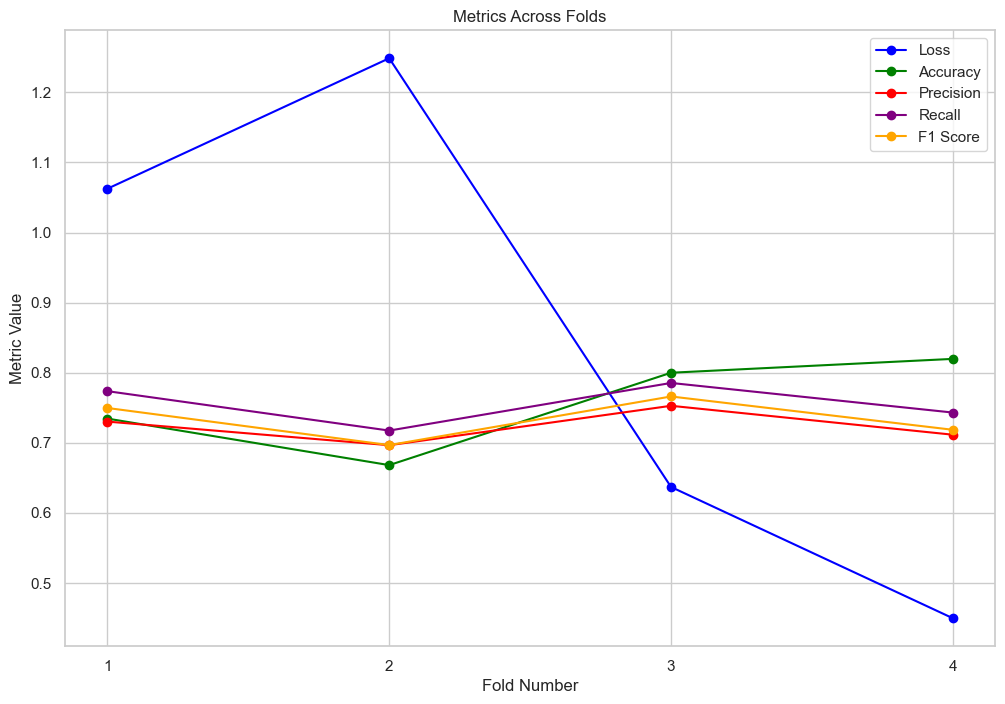

In [107]:
seed_1_folds_values = [unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1]

seed_1_training_acc_values = cv_training_acc_total

# Plotting all fold metrics
seed_1_folds_plot = plot_all_metrics(unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1, "Folds", "Fold Number")

## Majority Voting on Total Entries per cat_id 

In [108]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 859, Predictions: 859, Actuals: 859, Gender: 859


In [109]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [110]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

# store for final evaluation 
all_majority_vote_accuracies.append(majority_vote_accuracy)

Overall Majority Vote Accuracy for cat_id: 0.78 (86/110)


In [111]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [112]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,000B,"[adult, adult, adult, senior, adult, adult, ad...",adult,adult,True
68,062A,"[adult, adult, adult, adult]",adult,adult,True
79,073A,[adult],adult,adult,True
78,072A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
77,071A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
76,070A,"[adult, adult, adult, adult, senior]",adult,adult,True
75,069A,"[adult, adult]",adult,adult,True
73,067A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
72,066A,[adult],adult,adult,True
71,065A,"[senior, adult, adult, adult, adult, senior, a...",adult,adult,True


In [113]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']

# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()

# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')

# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Count correct majority votes per class
correct_majority_votes_per_class = majority_with_actual.groupby('actual_age_group')['Majority_Correct'].sum()

print("Correct Majority Votes per Class:")
print(correct_majority_votes_per_class)

Correct Majority Votes per Class:
actual_age_group
adult     59
kitten    12
senior    15
Name: Majority_Correct, dtype: int64


In [114]:
# Calculate the total count and the number of correct predictions for each class
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    total_count=('Majority_Correct', 'size'),  # Total number of cases per class
    correct_count=('Majority_Correct', 'sum')  # Sum of correct predictions per class
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# store for final evaluation 
all_majority_vote_details.append(class_stats)

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
  actual_age_group  total_count  correct_count   accuracy
0            adult           73             59  80.821918
1           kitten           15             12  80.000000
2           senior           22             15  68.181818


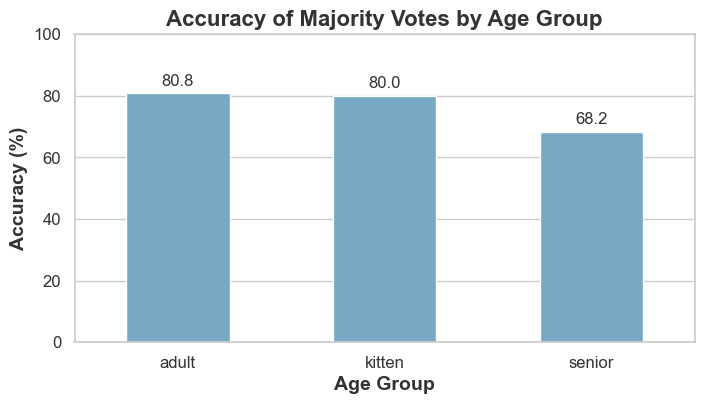

In [115]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')


## Detailed Class Statistics

In [116]:
# Calculate the total count and the number of correct predictions for each class
class_stats = full_results.groupby('actual_age_group').agg(
    total_count=('correct', 'size'),
    correct_count=('correct', 'sum')
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# store for final evaluation 
all_class_stats.append(class_stats)

# Log the detailed stats
print("Detailed Class Statistics:")
print(class_stats)

Detailed Class Statistics:
  actual_age_group  total_count  correct_count   accuracy
0            adult          572            444  77.622378
1           kitten          109             94  86.238532
2           senior          178            113  63.483146


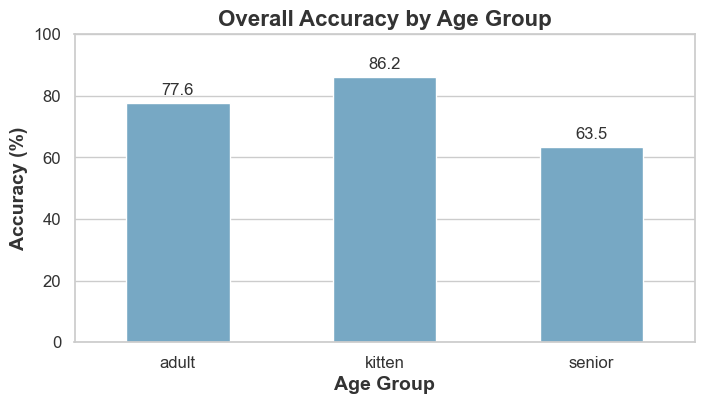

In [117]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [118]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

# store for final evaluation 
all_gender_stats.append(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F    213      178     83.57
1          M    360      255     70.83
2          X    286      218     76.22


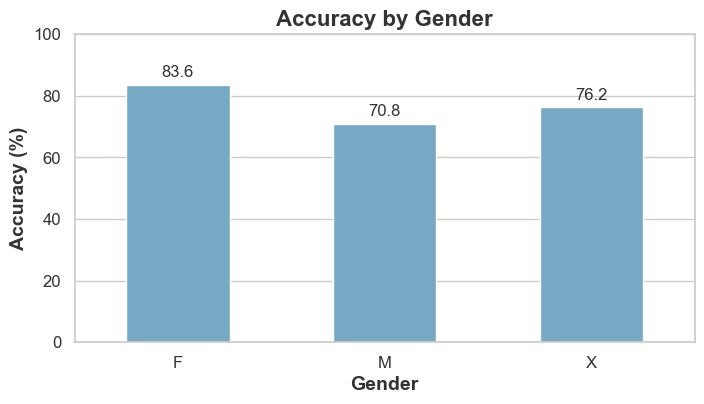

In [119]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

### Log current total CV Stats

In [120]:
print("Total Majority Vote Accuracy so far:", all_majority_vote_accuracies)
print("Total Class Statistics so far:\n", all_class_stats)
print("Total Gender Accuracy so far:\n", all_gender_stats)

Total Majority Vote Accuracy so far: [0.7818181818181819]
Total Class Statistics so far:
 [  actual_age_group  total_count  correct_count   accuracy
0            adult          572            444  77.622378
1           kitten          109             94  86.238532
2           senior          178            113  63.483146]
Total Gender Accuracy so far:
 [  all_gender  count  correct  accuracy
0          F    213      178     83.57
1          M    360      255     70.83
2          X    286      218     76.22]


# RANDOM SEED 2

In [121]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[1]))
np.random.seed(int(random_seeds[1]))
tf.random.set_seed(int(random_seeds[1]))

# Load datasets
dataframe = pd.read_csv('/Users/astrid/PycharmProjects/audioset-thesis-work/audioset/vggish/embeddings/8april_looped_embeddings.csv')
augmented_df = pd.read_csv('/Users/astrid/PycharmProjects/audioset-thesis-work/audioset/vggish/embeddings/augmented_dataset_19.csv')

dataframe.drop('mean_freq', axis=1, inplace=True)

augmented_df.drop('gender', axis=1, inplace=True)

def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 12),
    'senior': (12, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)
augmented_df['age_group'] = augmented_df['target'].apply(assign_age_group, age_groups=age_groups)

print(dataframe['age_group'].value_counts())
print(augmented_df['age_group'].value_counts())

adult     588
senior    178
kitten    171
Name: age_group, dtype: int64
adult     588
senior    534
kitten    513
Name: age_group, dtype: int64


In [122]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [123]:
tf.keras.backend.clear_session()

## Run Setup

In [124]:
all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[1]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

cv_training_acc_total = []
cv_training_acc_best = []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['000A', '046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ######################
    # ADD AUGMENTED DATA #
    ######################

    # Filter out augmented data derived from groups in the training set
    augmented_df_filtered = augmented_df[augmented_df['cat_id'].isin(groups_train_val)]
    
    # Convert augmented_df_filtered to numpy array (excluding target and other columns)
    augmented_array = augmented_df_filtered.drop(columns=['target', 'cat_id', 'age_group']).values
    
    # Concatenate the filtered augmented data with X_train_val
    X_train_val = np.concatenate([X_train_val, augmented_array])

    # Extract target labels from the filtered augmented DataFrame
    y_augmented = augmented_df_filtered['age_group'].values
    
    # Encode the labels using the same LabelEncoder instance
    y_augmented_encoded = label_encoder.transform(y_augmented)
    
    # Concatenate the encoded augmented labels with y_train_val
    y_train_val = np.concatenate([y_train_val, y_augmented_encoded])

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )

    accuracy_history = AccuracyHistory()

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]
    
    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = to_categorical(y_train_val)
    y_test_encoded = to_categorical(y_test)

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    optimizers = {
        'Adamax': Adamax(learning_rate=0.00038188800331973483)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(480, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))  # units_l0 and activation from parameters
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.27188281261238406))  
    model_full.add(Dense(3, activation='softmax'))  
    
    optimizer = optimizers['Adamax']  # optimizer_key from parameters
    
    # Compile the model
    model_full.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=32,
                                  verbose=1, callbacks=[early_stopping, accuracy_history])
    
    # log epochs
    best_epoch_index = np.argmin(history_full.history['loss'])  
    best_training_accuracy = accuracy_history.acc[best_epoch_index]

    # Append training acc to total  
    all_best_training_acc.append(best_training_accuracy)
    total_training_acc.append(accuracy_history.acc)

    # Append training acc just for this CV
    cv_training_acc_total.append(accuracy_history.acc)
    cv_training_acc_best.append(best_training_accuracy)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    y_test_pred_prob = model_full.predict(X_test_scaled)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    y_test_true = np.argmax(y_test_encoded, axis=1)    

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = label_encoder.inverse_transform(y_test_pred)
    actual_labels = label_encoder.inverse_transform(y_test_true)
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)

# Append averages to total lists
average_fold_f1.append(unseen_set_avg_f1)
average_fold_losses.append(unseen_set_avg_loss)
average_fold_accuracies.append(unseen_set_avg_acc)
average_fold_precisions.append(unseen_set_avg_precision)
average_fold_recalls.append(unseen_set_avg_recall)

# Append all to total lists
all_f1.append(unseen_f1)
all_losses.append(unseen_losses)
all_accuracies.append(unseen_accuracies)
all_precisions.append(unseen_precisions)
all_recalls.append(unseen_recalls)
        


outer_fold 1
Train Set Group Distribution:
046A    63
000A    39
057A    27
020A    23
055A    20
000B    19
067A    19
019A    17
029A    17
106A    14
097B    14
001A    14
059A    14
028A    13
002A    13
039A    12
116A    12
063A    11
025A    11
005A    10
040A    10
016A    10
071A    10
022A     9
051B     9
072A     9
065A     9
045A     9
033A     9
013B     8
094A     8
010A     8
095A     8
027A     7
117A     7
031A     7
109A     6
108A     6
053A     6
008A     6
023A     6
037A     6
007A     6
034A     5
025C     5
070A     5
023B     5
044A     5
075A     5
035A     4
062A     4
026A     4
105A     4
104A     4
052A     4
009A     4
060A     3
012A     3
006A     3
064A     3
058A     3
054A     2
061A     2
087A     2
069A     2
032A     2
011A     2
018A     2
025B     2
093A     2
088A     1
091A     1
100A     1
090A     1
019B     1
115A     1
066A     1
004A     1
048A     1
073A     1
026C     1
076A     1
041A     1
092A     1
049A     1
043A     1
026B     1


Majority Vote Accuracy for cat_id for this fold: 0.72 (18/25)
Before appending - Cat IDs: 0, Predictions: 0, Actuals: 0, Gender: 0
After appending - Cat IDs: 268, Predictions: 268, Actuals: 268, Gender: 268
Final Test Results - Loss: 0.8930092453956604, Accuracy: 0.6940298676490784, Precision: 0.6875, Recall: 0.6232183626875408, F1 Score: 0.6297404087981285
Confusion Matrix:
 [[129   2  29]
 [ 35  38   0]
 [ 16   0  19]]
outer_fold 2
Train Set Group Distribution:
000A    39
103A    33
002B    32
047A    28
057A    27
074A    25
020A    23
055A    20
000B    19
097A    16
101A    15
059A    14
042A    14
097B    14
106A    14
028A    13
002A    13
111A    13
039A    12
116A    12
051A    12
036A    11
068A    11
025A    11
014B    10
040A    10
016A    10
005A    10
071A    10
015A     9
013B     8
094A     8
010A     8
099A     7
050A     7
117A     7
031A     7
027A     7
053A     6
108A     6
023A     6
007A     6
025C     5
044A     5
023B     5
021A     5
070A     5
034A     5
003A

Majority Vote Accuracy for cat_id for this fold: 0.69 (20/29)
Before appending - Cat IDs: 268, Predictions: 268, Actuals: 268, Gender: 268
After appending - Cat IDs: 459, Predictions: 459, Actuals: 459, Gender: 459
Final Test Results - Loss: 0.7387664914131165, Accuracy: 0.7696335315704346, Precision: 0.5589834515366431, Recall: 0.6360471070148489, F1 Score: 0.5881722058192647
Confusion Matrix:
 [[126  14  15]
 [  5  16   0]
 [ 10   0   5]]
outer_fold 3
Train Set Group Distribution:
046A    63
000A    39
103A    33
002B    32
047A    28
057A    27
074A    25
055A    20
067A    19
019A    17
029A    17
097A    16
101A    15
001A    14
042A    14
097B    14
111A    13
039A    12
051A    12
036A    11
068A    11
063A    11
040A    10
014B    10
022A     9
072A     9
065A     9
033A     9
051B     9
045A     9
015A     9
094A     8
095A     8
117A     7
050A     7
099A     7
027A     7
031A     7
008A     6
109A     6
053A     6
037A     6
108A     6
023A     6
023B     5
075A     5
021A  

AFTER SWAP - Unique Training/Validation Group IDs:
['000A' '000B' '001A' '002A' '002B' '003A' '005A' '006A' '007A' '008A'
 '009A' '010A' '011A' '013B' '014A' '014B' '015A' '016A' '018A' '019A'
 '020A' '021A' '022A' '024A' '025A' '025B' '025C' '026B' '026C' '028A'
 '029A' '032A' '033A' '034A' '036A' '037A' '038A' '042A' '043A' '044A'
 '045A' '046A' '047A' '049A' '050A' '051A' '051B' '054A' '056A' '059A'
 '060A' '061A' '063A' '064A' '065A' '066A' '067A' '068A' '070A' '071A'
 '072A' '074A' '076A' '087A' '090A' '091A' '093A' '095A' '096A' '097A'
 '099A' '100A' '101A' '102A' '103A' '104A' '105A' '106A' '109A' '110A'
 '111A' '113A' '115A' '116A']
AFTER SWAP - Unique Test Group IDs:
['004A' '012A' '019B' '023A' '023B' '026A' '027A' '031A' '035A' '039A'
 '040A' '041A' '048A' '052A' '053A' '055A' '057A' '058A' '062A' '069A'
 '073A' '075A' '088A' '092A' '094A' '097B' '108A' '117A']
Length of X_train_val:
766
Length of y_train_val:
766
Length of groups_train_val:
766
No common groups found betwee

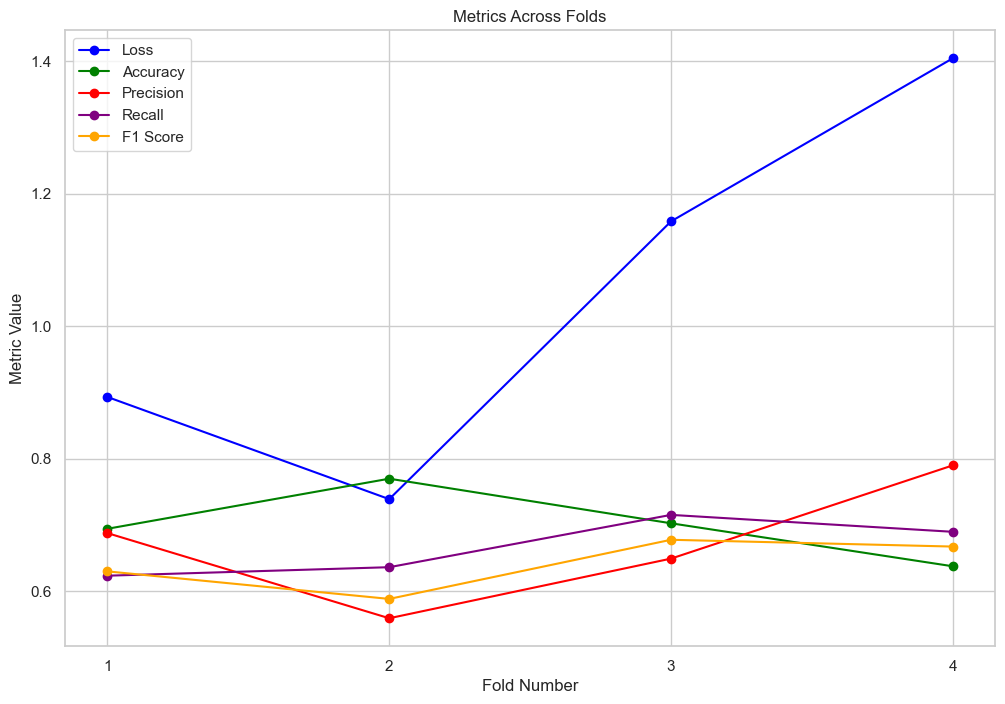

In [125]:
seed_2_folds_values = [unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1]

seed_2_training_acc_values = cv_training_acc_total

# Plotting all fold metrics
seed_2_folds_plot = plot_all_metrics(unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1, "Folds", "Fold Number")

## Majority Voting on Total Entries per cat_id 

In [126]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 845, Predictions: 845, Actuals: 845, Gender: 845


In [127]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [128]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

# store for final evaluation 
all_majority_vote_accuracies.append(majority_vote_accuracy)

Overall Majority Vote Accuracy for cat_id: 0.72 (79/110)


In [129]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [130]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,000B,"[adult, adult, kitten, adult, adult, adult, ad...",adult,adult,True
68,062A,"[adult, adult, adult, adult]",adult,adult,True
77,071A,"[adult, senior, adult, adult, adult, adult, ad...",adult,adult,True
76,070A,"[adult, senior, adult, adult, senior]",adult,adult,True
75,069A,"[adult, adult]",adult,adult,True
74,068A,"[adult, adult, adult, senior, senior, adult, s...",adult,adult,True
73,067A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
72,066A,[adult],adult,adult,True
71,065A,"[senior, adult, adult, adult, adult, senior, a...",adult,adult,True
70,064A,"[adult, adult, adult]",adult,adult,True


In [131]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']

# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()

# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')

# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Count correct majority votes per class
correct_majority_votes_per_class = majority_with_actual.groupby('actual_age_group')['Majority_Correct'].sum()

print("Correct Majority Votes per Class:")
print(correct_majority_votes_per_class)

Correct Majority Votes per Class:
actual_age_group
adult     60
kitten    10
senior     9
Name: Majority_Correct, dtype: int64


In [132]:
# Calculate the total count and the number of correct predictions for each class
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    total_count=('Majority_Correct', 'size'),  # Total number of cases per class
    correct_count=('Majority_Correct', 'sum')  # Sum of correct predictions per class
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# store for final evaluation 
all_majority_vote_details.append(class_stats)

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
  actual_age_group  total_count  correct_count   accuracy
0            adult           73             60  82.191781
1           kitten           15             10  66.666667
2           senior           22              9  40.909091


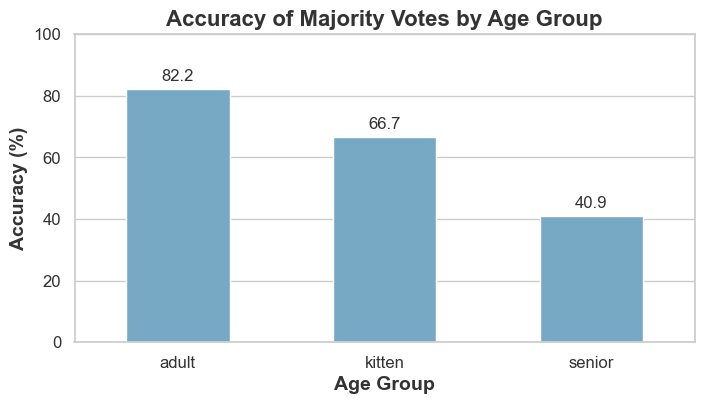

In [133]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')


## Detailed Class Statistics

In [134]:
# Calculate the total count and the number of correct predictions for each class
class_stats = full_results.groupby('actual_age_group').agg(
    total_count=('correct', 'size'),
    correct_count=('correct', 'sum')
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# store for final evaluation 
all_class_stats.append(class_stats)

# Log the detailed stats
print("Detailed Class Statistics:")
print(class_stats)

Detailed Class Statistics:
  actual_age_group  total_count  correct_count   accuracy
0            adult          554            454  81.949458
1           kitten          113             71  62.831858
2           senior          178             68  38.202247


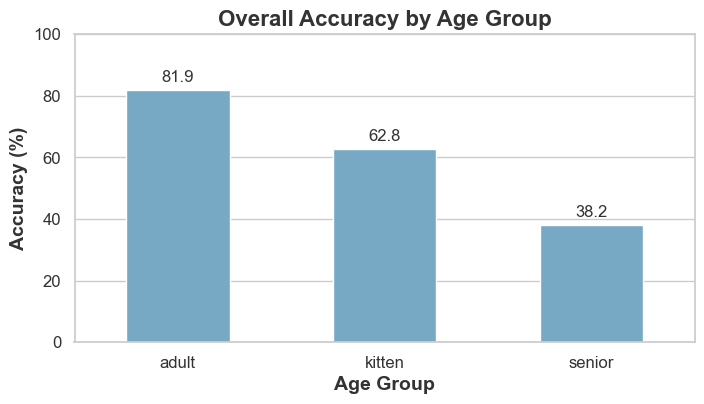

In [135]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [136]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

# store for final evaluation 
all_gender_stats.append(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F    213      143     67.14
1          M    342      265     77.49
2          X    290      185     63.79


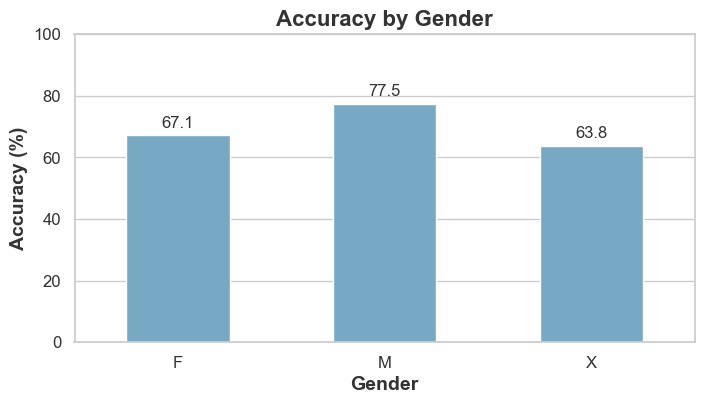

In [137]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

### Log current total CV Stats

In [138]:
print("Total Majority Vote Accuracy so far:", all_majority_vote_accuracies)
print("Total Class Statistics so far:\n", all_class_stats)
print("Total Gender Accuracy so far:\n", all_gender_stats)

Total Majority Vote Accuracy so far: [0.7818181818181819, 0.7181818181818181]
Total Class Statistics so far:
 [  actual_age_group  total_count  correct_count   accuracy
0            adult          572            444  77.622378
1           kitten          109             94  86.238532
2           senior          178            113  63.483146,   actual_age_group  total_count  correct_count   accuracy
0            adult          554            454  81.949458
1           kitten          113             71  62.831858
2           senior          178             68  38.202247]
Total Gender Accuracy so far:
 [  all_gender  count  correct  accuracy
0          F    213      178     83.57
1          M    360      255     70.83
2          X    286      218     76.22,   all_gender  count  correct  accuracy
0          F    213      143     67.14
1          M    342      265     77.49
2          X    290      185     63.79]


# RANDOM SEED 3

In [139]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[2]))
np.random.seed(int(random_seeds[2]))
tf.random.set_seed(int(random_seeds[2]))

# Load datasets
dataframe = pd.read_csv('/Users/astrid/PycharmProjects/audioset-thesis-work/audioset/vggish/embeddings/8april_looped_embeddings.csv')
augmented_df = pd.read_csv('/Users/astrid/PycharmProjects/audioset-thesis-work/audioset/vggish/embeddings/augmented_dataset_19.csv')

dataframe.drop('mean_freq', axis=1, inplace=True)

augmented_df.drop('gender', axis=1, inplace=True)

def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 12),
    'senior': (12, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)
augmented_df['age_group'] = augmented_df['target'].apply(assign_age_group, age_groups=age_groups)

print(dataframe['age_group'].value_counts())
print(augmented_df['age_group'].value_counts())

adult     588
senior    178
kitten    171
Name: age_group, dtype: int64
adult     588
senior    534
kitten    513
Name: age_group, dtype: int64


In [140]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [141]:
tf.keras.backend.clear_session()

## Run Setup

In [142]:
all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[2]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

cv_training_acc_total = []
cv_training_acc_best = []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['000A', '046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ######################
    # ADD AUGMENTED DATA #
    ######################

    # Filter out augmented data derived from groups in the training set
    augmented_df_filtered = augmented_df[augmented_df['cat_id'].isin(groups_train_val)]
    
    # Convert augmented_df_filtered to numpy array (excluding target and other columns)
    augmented_array = augmented_df_filtered.drop(columns=['target', 'cat_id', 'age_group']).values
    
    # Concatenate the filtered augmented data with X_train_val
    X_train_val = np.concatenate([X_train_val, augmented_array])

    # Extract target labels from the filtered augmented DataFrame
    y_augmented = augmented_df_filtered['age_group'].values
    
    # Encode the labels using the same LabelEncoder instance
    y_augmented_encoded = label_encoder.transform(y_augmented)
    
    # Concatenate the encoded augmented labels with y_train_val
    y_train_val = np.concatenate([y_train_val, y_augmented_encoded])

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )

    accuracy_history = AccuracyHistory()

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]
    
    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = to_categorical(y_train_val)
    y_test_encoded = to_categorical(y_test)

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    optimizers = {
        'Adamax': Adamax(learning_rate=0.00038188800331973483)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(480, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))  # units_l0 and activation from parameters
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.27188281261238406))  
    model_full.add(Dense(3, activation='softmax'))  
    
    optimizer = optimizers['Adamax']  # optimizer_key from parameters
    
    # Compile the model
    model_full.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=32,
                                  verbose=1, callbacks=[early_stopping, accuracy_history])
    
    # log epochs
    best_epoch_index = np.argmin(history_full.history['loss'])  
    best_training_accuracy = accuracy_history.acc[best_epoch_index]

    # Append training acc to total  
    all_best_training_acc.append(best_training_accuracy)
    total_training_acc.append(accuracy_history.acc)

    # Append training acc just for this CV
    cv_training_acc_total.append(accuracy_history.acc)
    cv_training_acc_best.append(best_training_accuracy)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    y_test_pred_prob = model_full.predict(X_test_scaled)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    y_test_true = np.argmax(y_test_encoded, axis=1)    

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = label_encoder.inverse_transform(y_test_pred)
    actual_labels = label_encoder.inverse_transform(y_test_true)
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)

# Append averages to total lists
average_fold_f1.append(unseen_set_avg_f1)
average_fold_losses.append(unseen_set_avg_loss)
average_fold_accuracies.append(unseen_set_avg_acc)
average_fold_precisions.append(unseen_set_avg_precision)
average_fold_recalls.append(unseen_set_avg_recall)

# Append all to total lists
all_f1.append(unseen_f1)
all_losses.append(unseen_losses)
all_accuracies.append(unseen_accuracies)
all_precisions.append(unseen_precisions)
all_recalls.append(unseen_recalls)
        


outer_fold 1
Train Set Group Distribution:
046A    63
000A    39
103A    33
002B    32
047A    28
057A    27
020A    23
055A    20
067A    19
097A    16
101A    15
042A    14
106A    14
059A    14
028A    13
002A    13
039A    12
116A    12
063A    11
025A    11
071A    10
016A    10
040A    10
014B    10
033A     9
072A     9
015A     9
022A     9
051B     9
065A     9
095A     8
013B     8
010A     8
094A     8
027A     7
099A     7
031A     7
050A     7
108A     6
109A     6
037A     6
007A     6
008A     6
025C     5
070A     5
021A     5
034A     5
075A     5
023B     5
035A     4
009A     4
026A     4
062A     4
003A     4
012A     3
060A     3
064A     3
006A     3
113A     3
056A     3
058A     3
014A     3
011A     2
061A     2
032A     2
093A     2
025B     2
087A     2
069A     2
073A     1
115A     1
088A     1
100A     1
090A     1
024A     1
019B     1
066A     1
004A     1
048A     1
026C     1
041A     1
092A     1
049A     1
076A     1
096A     1
043A     1
026B     1


Count of Unique Cat IDs per Age Group in Training/Validation Set:
{'adult': 56, 'kitten': 12, 'senior': 16}
Count of Unique Cat IDs per Age Group in Testing Set:
{'adult': 18, 'kitten': 4, 'senior': 6}
Unique Training/Validation Group IDs:
['000B' '001A' '002A' '003A' '005A' '006A' '007A' '008A' '009A' '010A'
 '012A' '013B' '014A' '018A' '019A' '020A' '021A' '022A' '023A' '024A'
 '025A' '025B' '025C' '026A' '026B' '026C' '027A' '028A' '029A' '031A'
 '032A' '033A' '034A' '035A' '036A' '037A' '038A' '041A' '044A' '045A'
 '046A' '047A' '048A' '049A' '050A' '051A' '052A' '053A' '054A' '055A'
 '056A' '057A' '058A' '059A' '064A' '066A' '067A' '068A' '072A' '073A'
 '074A' '087A' '088A' '090A' '091A' '093A' '094A' '096A' '097A' '097B'
 '099A' '100A' '101A' '102A' '103A' '104A' '105A' '108A' '109A' '110A'
 '111A' '113A' '115A' '117A']
Unique Test Group IDs:
['000A' '002B' '004A' '011A' '014B' '015A' '016A' '019B' '023B' '039A'
 '040A' '042A' '043A' '051B' '060A' '061A' '062A' '063A' '065A' '069

Majority Vote Accuracy for cat_id for this fold: 0.79 (22/28)
Before appending - Cat IDs: 218, Predictions: 218, Actuals: 218, Gender: 218
After appending - Cat IDs: 423, Predictions: 423, Actuals: 423, Gender: 423
Final Test Results - Loss: 1.0802323818206787, Accuracy: 0.7463414669036865, Precision: 0.7312445707968096, Recall: 0.7122842525439927, F1 Score: 0.7164766376033982
Confusion Matrix:
 [[102   5  14]
 [  3  31   1]
 [ 29   0  20]]
outer_fold 3
Train Set Group Distribution:
000A    39
103A    33
002B    32
047A    28
057A    27
074A    25
055A    20
000B    19
019A    17
029A    17
101A    15
001A    14
097B    14
042A    14
106A    14
111A    13
028A    13
002A    13
051A    12
116A    12
039A    12
068A    11
025A    11
036A    11
063A    11
014B    10
040A    10
071A    10
005A    10
016A    10
051B     9
033A     9
065A     9
015A     9
045A     9
095A     8
117A     7
099A     7
031A     7
023A     6
007A     6
108A     6
053A     6
021A     5
023B     5
025C     5
070A  

Majority Vote Accuracy for cat_id for this fold: 0.77 (23/30)
Before appending - Cat IDs: 423, Predictions: 423, Actuals: 423, Gender: 423
After appending - Cat IDs: 604, Predictions: 604, Actuals: 604, Gender: 604
Final Test Results - Loss: 0.5064430832862854, Accuracy: 0.7900552749633789, Precision: 0.7904687904687905, Recall: 0.6803874092009686, F1 Score: 0.7205751633986929
Confusion Matrix:
 [[106   2  10]
 [ 10  11   0]
 [ 16   0  26]]
outer_fold 4
Train Set Group Distribution:
046A    63
000A    39
002B    32
074A    25
020A    23
000B    19
067A    19
029A    17
019A    17
097A    16
001A    14
097B    14
106A    14
059A    14
042A    14
111A    13
039A    12
051A    12
116A    12
068A    11
036A    11
063A    11
016A    10
005A    10
040A    10
014B    10
071A    10
022A     9
015A     9
065A     9
045A     9
072A     9
051B     9
095A     8
013B     8
010A     8
094A     8
027A     7
050A     7
117A     7
037A     6
053A     6
008A     6
109A     6
023A     6
044A     5
023B  

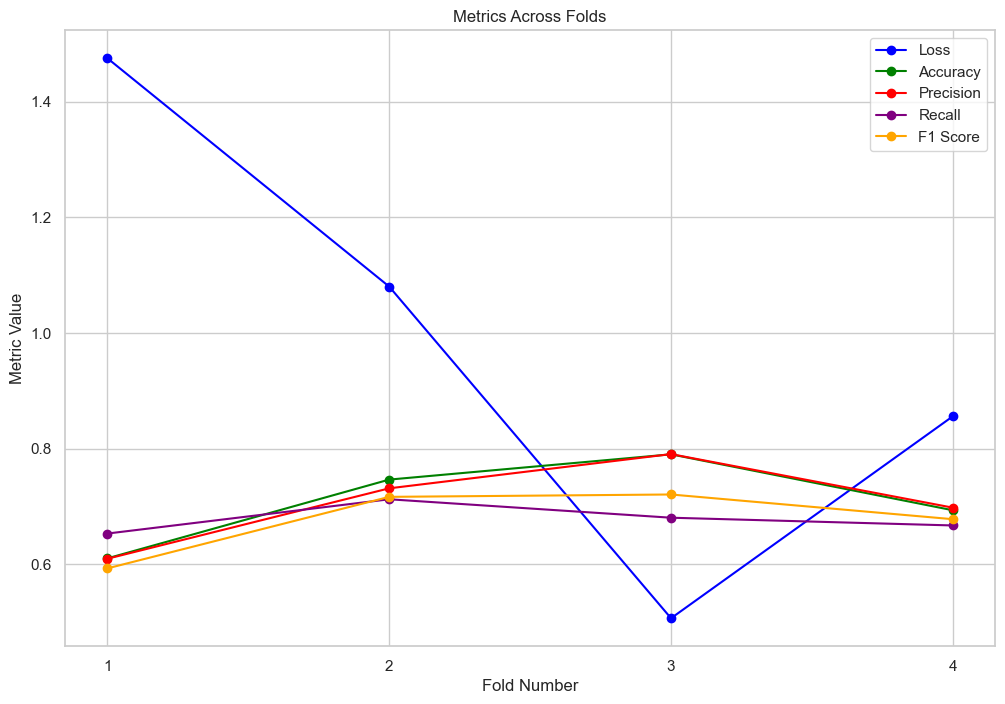

In [143]:
seed_3_folds_values = [unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1]

seed_3_training_acc_values = cv_training_acc_total

# Plotting all fold metrics
seed_3_folds_plot = plot_all_metrics(unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1, "Folds", "Fold Number")

## Majority Voting on Total Entries per cat_id 

In [144]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 842, Predictions: 842, Actuals: 842, Gender: 842


In [145]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [146]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

# store for final evaluation 
all_majority_vote_accuracies.append(majority_vote_accuracy)

Overall Majority Vote Accuracy for cat_id: 0.72 (79/110)


In [147]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [148]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,000B,"[adult, adult, kitten, senior, adult, senior, ...",adult,adult,True
81,075A,"[adult, adult, adult, adult, adult]",adult,adult,True
79,073A,[adult],adult,adult,True
78,072A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
77,071A,"[adult, senior, adult, adult, adult, adult, ad...",adult,adult,True
76,070A,"[adult, adult, adult, adult, senior]",adult,adult,True
75,069A,"[adult, adult]",adult,adult,True
73,067A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
72,066A,[adult],adult,adult,True
71,065A,"[senior, adult, adult, adult, kitten, senior, ...",adult,adult,True


In [149]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']

# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()

# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')

# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Count correct majority votes per class
correct_majority_votes_per_class = majority_with_actual.groupby('actual_age_group')['Majority_Correct'].sum()

print("Correct Majority Votes per Class:")
print(correct_majority_votes_per_class)

Correct Majority Votes per Class:
actual_age_group
adult     60
kitten    12
senior     7
Name: Majority_Correct, dtype: int64


In [150]:
# Calculate the total count and the number of correct predictions for each class
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    total_count=('Majority_Correct', 'size'),  # Total number of cases per class
    correct_count=('Majority_Correct', 'sum')  # Sum of correct predictions per class
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# store for final evaluation 
all_majority_vote_details.append(class_stats)

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
  actual_age_group  total_count  correct_count   accuracy
0            adult           73             60  82.191781
1           kitten           15             12  80.000000
2           senior           22              7  31.818182


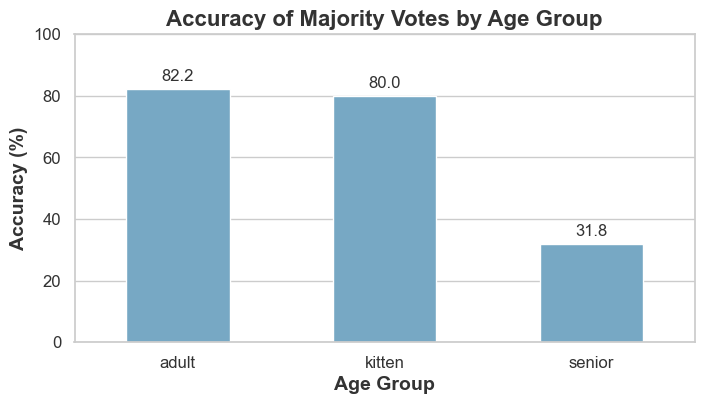

In [151]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')


## Detailed Class Statistics

In [152]:
# Calculate the total count and the number of correct predictions for each class
class_stats = full_results.groupby('actual_age_group').agg(
    total_count=('correct', 'size'),
    correct_count=('correct', 'sum')
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# store for final evaluation 
all_class_stats.append(class_stats)

# Log the detailed stats
print("Detailed Class Statistics:")
print(class_stats)

Detailed Class Statistics:
  actual_age_group  total_count  correct_count   accuracy
0            adult          551            424  76.950998
1           kitten          113             91  80.530973
2           senior          178             79  44.382022


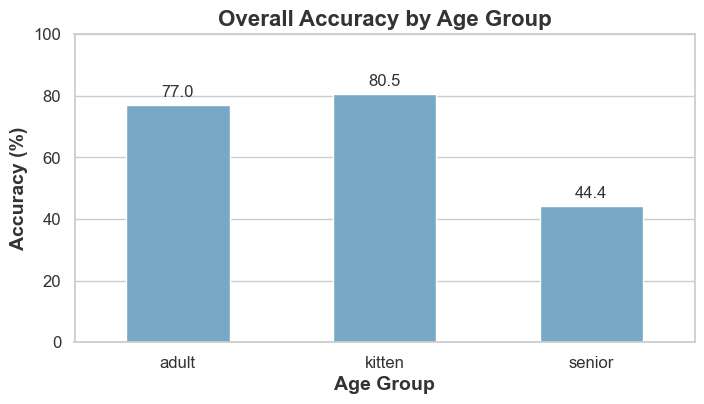

In [153]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [154]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

# store for final evaluation 
all_gender_stats.append(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F    215      147     68.37
1          M    337      241     71.51
2          X    290      206     71.03


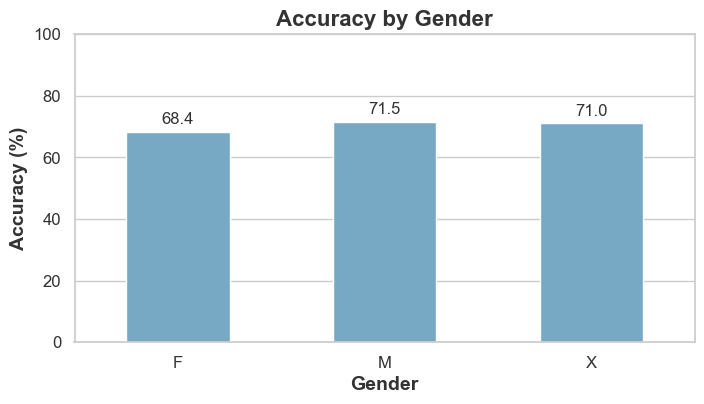

In [155]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

### Log current total CV Stats

In [156]:
print("Total Majority Vote Accuracy so far:", all_majority_vote_accuracies)
print("Total Class Statistics so far:\n", all_class_stats)
print("Total Gender Accuracy so far:\n", all_gender_stats)

Total Majority Vote Accuracy so far: [0.7818181818181819, 0.7181818181818181, 0.7181818181818181]
Total Class Statistics so far:
 [  actual_age_group  total_count  correct_count   accuracy
0            adult          572            444  77.622378
1           kitten          109             94  86.238532
2           senior          178            113  63.483146,   actual_age_group  total_count  correct_count   accuracy
0            adult          554            454  81.949458
1           kitten          113             71  62.831858
2           senior          178             68  38.202247,   actual_age_group  total_count  correct_count   accuracy
0            adult          551            424  76.950998
1           kitten          113             91  80.530973
2           senior          178             79  44.382022]
Total Gender Accuracy so far:
 [  all_gender  count  correct  accuracy
0          F    213      178     83.57
1          M    360      255     70.83
2          X    286  

# RANDOM SEED 4

In [157]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[3])) 
np.random.seed(int(random_seeds[3]))
tf.random.set_seed(int(random_seeds[3]))

# Load datasets
dataframe = pd.read_csv('/Users/astrid/PycharmProjects/audioset-thesis-work/audioset/vggish/embeddings/8april_looped_embeddings.csv')
augmented_df = pd.read_csv('/Users/astrid/PycharmProjects/audioset-thesis-work/audioset/vggish/embeddings/augmented_dataset_19.csv')

dataframe.drop('mean_freq', axis=1, inplace=True)

augmented_df.drop('gender', axis=1, inplace=True)

def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 12),
    'senior': (12, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)
augmented_df['age_group'] = augmented_df['target'].apply(assign_age_group, age_groups=age_groups)

print(dataframe['age_group'].value_counts())
print(augmented_df['age_group'].value_counts())

adult     588
senior    178
kitten    171
Name: age_group, dtype: int64
adult     588
senior    534
kitten    513
Name: age_group, dtype: int64


In [158]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [159]:
tf.keras.backend.clear_session()

## Run Setup

In [160]:
all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[3]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

cv_training_acc_total = []
cv_training_acc_best = []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['000A', '046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ######################
    # ADD AUGMENTED DATA #
    ######################

    # Filter out augmented data derived from groups in the training set
    augmented_df_filtered = augmented_df[augmented_df['cat_id'].isin(groups_train_val)]
    
    # Convert augmented_df_filtered to numpy array (excluding target and other columns)
    augmented_array = augmented_df_filtered.drop(columns=['target', 'cat_id', 'age_group']).values
    
    # Concatenate the filtered augmented data with X_train_val
    X_train_val = np.concatenate([X_train_val, augmented_array])

    # Extract target labels from the filtered augmented DataFrame
    y_augmented = augmented_df_filtered['age_group'].values
    
    # Encode the labels using the same LabelEncoder instance
    y_augmented_encoded = label_encoder.transform(y_augmented)
    
    # Concatenate the encoded augmented labels with y_train_val
    y_train_val = np.concatenate([y_train_val, y_augmented_encoded])

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )

    accuracy_history = AccuracyHistory()

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]
    
    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = to_categorical(y_train_val)
    y_test_encoded = to_categorical(y_test)

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    optimizers = {
        'Adamax': Adamax(learning_rate=0.00038188800331973483)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(480, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))  # units_l0 and activation from parameters
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.27188281261238406))  
    model_full.add(Dense(3, activation='softmax'))  
    
    optimizer = optimizers['Adamax']  # optimizer_key from parameters
    
    # Compile the model
    model_full.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=32,
                                  verbose=1, callbacks=[early_stopping, accuracy_history])
    
    # log epochs
    best_epoch_index = np.argmin(history_full.history['loss'])  
    best_training_accuracy = accuracy_history.acc[best_epoch_index]

    # Append training acc to total  
    all_best_training_acc.append(best_training_accuracy)
    total_training_acc.append(accuracy_history.acc)

    # Append training acc just for this CV
    cv_training_acc_total.append(accuracy_history.acc)
    cv_training_acc_best.append(best_training_accuracy)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    y_test_pred_prob = model_full.predict(X_test_scaled)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    y_test_true = np.argmax(y_test_encoded, axis=1)    

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = label_encoder.inverse_transform(y_test_pred)
    actual_labels = label_encoder.inverse_transform(y_test_true)
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)

# Append averages to total lists
average_fold_f1.append(unseen_set_avg_f1)
average_fold_losses.append(unseen_set_avg_loss)
average_fold_accuracies.append(unseen_set_avg_acc)
average_fold_precisions.append(unseen_set_avg_precision)
average_fold_recalls.append(unseen_set_avg_recall)

# Append all to total lists
all_f1.append(unseen_f1)
all_losses.append(unseen_losses)
all_accuracies.append(unseen_accuracies)
all_precisions.append(unseen_precisions)
all_recalls.append(unseen_recalls)
        


outer_fold 1
Train Set Group Distribution:
046A    63
000A    39
103A    33
002B    32
047A    28
057A    27
074A    25
020A    23
055A    20
067A    19
000B    19
029A    17
097A    16
059A    14
042A    14
001A    14
097B    14
106A    14
111A    13
028A    13
002A    13
051A    12
116A    12
036A    11
068A    11
025A    11
014B    10
016A    10
040A    10
072A     9
015A     9
051B     9
022A     9
033A     9
045A     9
095A     8
013B     8
117A     7
031A     7
027A     7
007A     6
108A     6
053A     6
109A     6
023A     6
037A     6
075A     5
070A     5
025C     5
021A     5
034A     5
044A     5
023B     5
003A     4
105A     4
035A     4
026A     4
052A     4
062A     4
012A     3
113A     3
058A     3
060A     3
064A     3
006A     3
025B     2
032A     2
093A     2
054A     2
069A     2
087A     2
038A     2
073A     1
004A     1
090A     1
110A     1
115A     1
091A     1
019B     1
066A     1
048A     1
092A     1
026C     1
076A     1
043A     1
041A     1
024A     1


Majority Vote Accuracy for cat_id for this fold: 0.84 (21/25)
Before appending - Cat IDs: 0, Predictions: 0, Actuals: 0, Gender: 0
After appending - Cat IDs: 147, Predictions: 147, Actuals: 147, Gender: 147
Final Test Results - Loss: 0.5439038872718811, Accuracy: 0.8163265585899353, Precision: 0.7515634446327515, Recall: 0.8659356725146199, F1 Score: 0.7849062702003878
Confusion Matrix:
 [[97  1 22]
 [ 0  8  0]
 [ 4  0 15]]
outer_fold 2
Train Set Group Distribution:
046A    63
000A    39
103A    33
047A    28
057A    27
074A    25
000B    19
019A    17
097A    16
101A    15
106A    14
042A    14
059A    14
001A    14
028A    13
002A    13
111A    13
116A    12
039A    12
051A    12
063A    11
025A    11
036A    11
040A    10
016A    10
005A    10
071A    10
014B    10
022A     9
065A     9
051B     9
072A     9
010A     8
013B     8
095A     8
094A     8
031A     7
050A     7
117A     7
027A     7
099A     7
008A     6
108A     6
007A     6
023A     6
037A     6
023B     5
070A     5
0


Before appending - Cat IDs: 147, Predictions: 147, Actuals: 147, Gender: 147
After appending - Cat IDs: 355, Predictions: 355, Actuals: 355, Gender: 355
Final Test Results - Loss: 0.6583408117294312, Accuracy: 0.7644230723381042, Precision: 0.6217713365539453, Recall: 0.7661099369887676, F1 Score: 0.6662548507167182
Confusion Matrix:
 [[128  11  28]
 [  3  14   0]
 [  7   0  17]]
outer_fold 3
Train Set Group Distribution:
002B    32
047A    28
074A    25
020A    23
055A    20
000B    19
067A    19
019A    17
029A    17
097A    16
101A    15
097B    14
059A    14
028A    13
002A    13
039A    12
051A    12
063A    11
036A    11
068A    11
005A    10
016A    10
071A    10
065A     9
045A     9
022A     9
015A     9
033A     9
010A     8
094A     8
050A     7
031A     7
117A     7
099A     7
007A     6
108A     6
109A     6
008A     6
053A     6
075A     5
044A     5
021A     5
025C     5
034A     5
023B     5
009A     4
003A     4
104A     4
062A     4
113A     3
014A     3
056A     3
0

Majority Vote Accuracy for cat_id for this fold: 0.90 (27/30)
Before appending - Cat IDs: 355, Predictions: 355, Actuals: 355, Gender: 355
After appending - Cat IDs: 604, Predictions: 604, Actuals: 604, Gender: 604
Final Test Results - Loss: 0.8188357949256897, Accuracy: 0.7550200819969177, Precision: 0.7770975056689342, Recall: 0.7376010233153091, F1 Score: 0.754777647884031
Confusion Matrix:
 [[111   1  23]
 [  7  41   1]
 [ 29   0  36]]
outer_fold 4
Train Set Group Distribution:
046A    63
000A    39
103A    33
002B    32
057A    27
020A    23
055A    20
067A    19
019A    17
029A    17
101A    15
097B    14
042A    14
001A    14
106A    14
111A    13
039A    12
116A    12
068A    11
025A    11
063A    11
040A    10
071A    10
014B    10
005A    10
072A     9
065A     9
015A     9
033A     9
051B     9
045A     9
094A     8
010A     8
095A     8
013B     8
050A     7
027A     7
099A     7
053A     6
109A     6
008A     6
037A     6
023A     6
025C     5
070A     5
075A     5
035A   

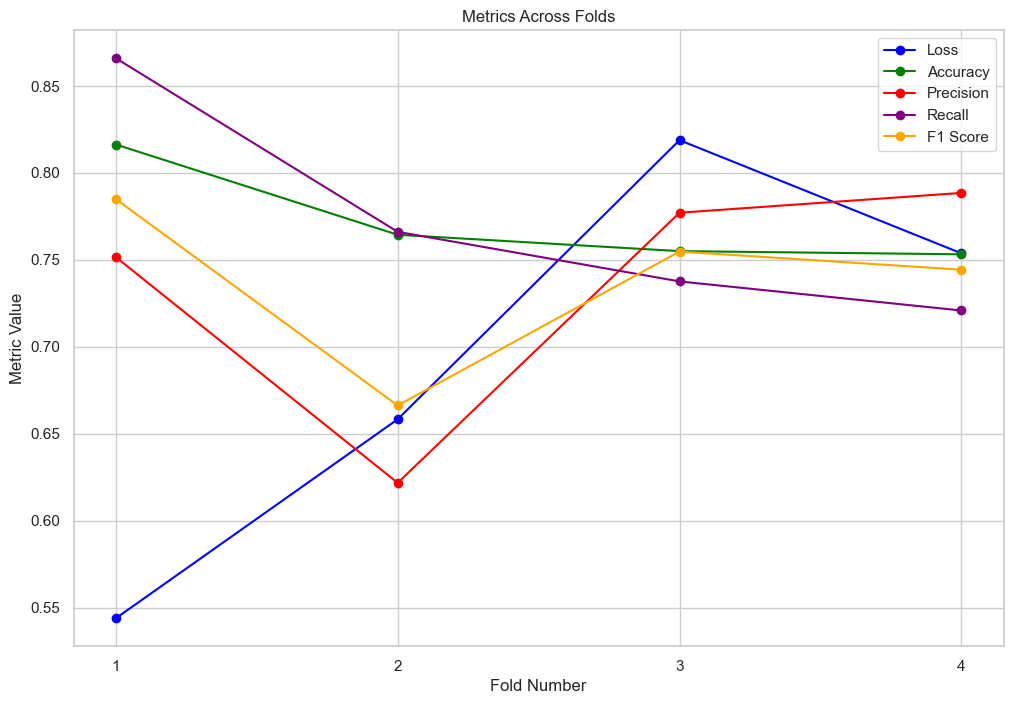

In [161]:
seed_4_folds_values = [unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1]

seed_4_training_acc_values = cv_training_acc_total

# Plotting all fold metrics
seed_4_folds_plot = plot_all_metrics(unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1, "Folds", "Fold Number")

## Majority Voting on Total Entries per cat_id 

In [162]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 839, Predictions: 839, Actuals: 839, Gender: 839


In [163]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [164]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

# store for final evaluation 
all_majority_vote_accuracies.append(majority_vote_accuracy)

Overall Majority Vote Accuracy for cat_id: 0.81 (89/110)


In [165]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [166]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,000B,"[adult, adult, kitten, adult, adult, adult, ad...",adult,adult,True
80,074A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
78,072A,"[adult, adult, adult, senior, adult, adult, ad...",adult,adult,True
77,071A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
76,070A,"[adult, adult, adult, adult, senior]",adult,adult,True
75,069A,"[adult, adult]",adult,adult,True
74,068A,"[adult, adult, adult, senior, senior, adult, a...",adult,adult,True
73,067A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
72,066A,[adult],adult,adult,True
71,065A,"[senior, adult, adult, adult, adult, senior, a...",adult,adult,True


In [167]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']

# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()

# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')

# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Count correct majority votes per class
correct_majority_votes_per_class = majority_with_actual.groupby('actual_age_group')['Majority_Correct'].sum()

print("Correct Majority Votes per Class:")
print(correct_majority_votes_per_class)

Correct Majority Votes per Class:
actual_age_group
adult     65
kitten    12
senior    12
Name: Majority_Correct, dtype: int64


In [168]:
# Calculate the total count and the number of correct predictions for each class
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    total_count=('Majority_Correct', 'size'),  # Total number of cases per class
    correct_count=('Majority_Correct', 'sum')  # Sum of correct predictions per class
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# store for final evaluation 
all_majority_vote_details.append(class_stats)

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
  actual_age_group  total_count  correct_count   accuracy
0            adult           73             65  89.041096
1           kitten           15             12  80.000000
2           senior           22             12  54.545455


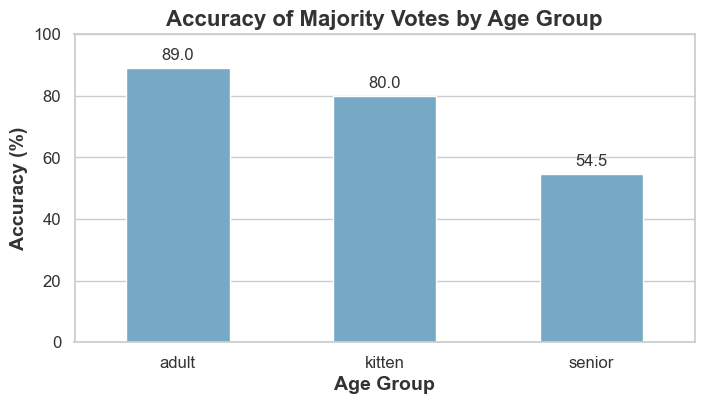

In [169]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')


## Detailed Class Statistics

In [170]:
# Calculate the total count and the number of correct predictions for each class
class_stats = full_results.groupby('actual_age_group').agg(
    total_count=('correct', 'size'),
    correct_count=('correct', 'sum')
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# store for final evaluation 
all_class_stats.append(class_stats)

# Log the detailed stats
print("Detailed Class Statistics:")
print(class_stats)

Detailed Class Statistics:
  actual_age_group  total_count  correct_count   accuracy
0            adult          552            450  81.521739
1           kitten          109             90  82.568807
2           senior          178            104  58.426966


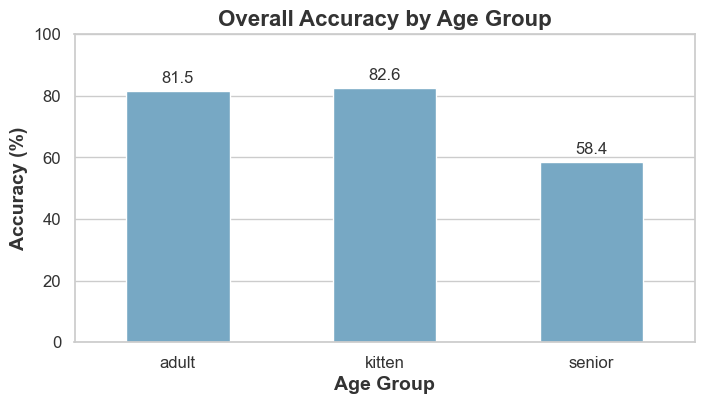

In [171]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [172]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

# store for final evaluation 
all_gender_stats.append(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F    216      163     75.46
1          M    337      266     78.93
2          X    286      215     75.17


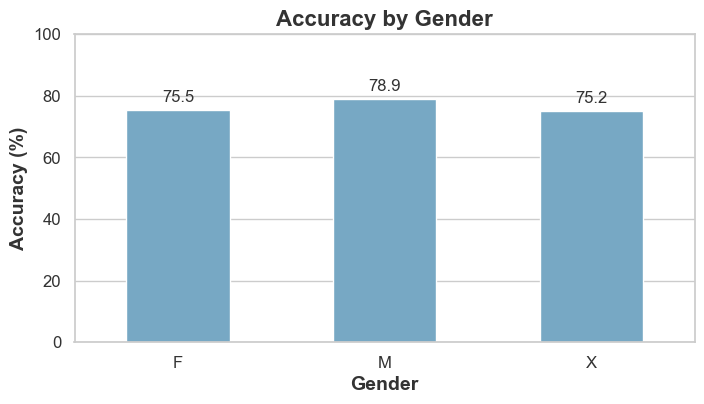

In [173]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

### Log current total CV Stats

In [174]:
print("Total Majority Vote Accuracy so far:", all_majority_vote_accuracies)
print("Total Class Statistics so far:\n", all_class_stats)
print("Total Gender Accuracy so far:\n", all_gender_stats)

Total Majority Vote Accuracy so far: [0.7818181818181819, 0.7181818181818181, 0.7181818181818181, 0.8090909090909091]
Total Class Statistics so far:
 [  actual_age_group  total_count  correct_count   accuracy
0            adult          572            444  77.622378
1           kitten          109             94  86.238532
2           senior          178            113  63.483146,   actual_age_group  total_count  correct_count   accuracy
0            adult          554            454  81.949458
1           kitten          113             71  62.831858
2           senior          178             68  38.202247,   actual_age_group  total_count  correct_count   accuracy
0            adult          551            424  76.950998
1           kitten          113             91  80.530973
2           senior          178             79  44.382022,   actual_age_group  total_count  correct_count   accuracy
0            adult          552            450  81.521739
1           kitten          109   

# RANDOM SEED 5

In [175]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[4]))
np.random.seed(int(random_seeds[4]))
tf.random.set_seed(int(random_seeds[4]))

# Load datasets
dataframe = pd.read_csv('/Users/astrid/PycharmProjects/audioset-thesis-work/audioset/vggish/embeddings/8april_looped_embeddings.csv')
augmented_df = pd.read_csv('/Users/astrid/PycharmProjects/audioset-thesis-work/audioset/vggish/embeddings/augmented_dataset_19.csv')

dataframe.drop('mean_freq', axis=1, inplace=True)

augmented_df.drop('gender', axis=1, inplace=True)

def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 12),
    'senior': (12, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)
augmented_df['age_group'] = augmented_df['target'].apply(assign_age_group, age_groups=age_groups)

print(dataframe['age_group'].value_counts())
print(augmented_df['age_group'].value_counts())

adult     588
senior    178
kitten    171
Name: age_group, dtype: int64
adult     588
senior    534
kitten    513
Name: age_group, dtype: int64


In [176]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [177]:
tf.keras.backend.clear_session()

## Run Setup

In [178]:
all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[4]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

cv_training_acc_total = []
cv_training_acc_best = []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['000A', '046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ######################
    # ADD AUGMENTED DATA #
    ######################

    # Filter out augmented data derived from groups in the training set
    augmented_df_filtered = augmented_df[augmented_df['cat_id'].isin(groups_train_val)]
    
    # Convert augmented_df_filtered to numpy array (excluding target and other columns)
    augmented_array = augmented_df_filtered.drop(columns=['target', 'cat_id', 'age_group']).values
    
    # Concatenate the filtered augmented data with X_train_val
    X_train_val = np.concatenate([X_train_val, augmented_array])

    # Extract target labels from the filtered augmented DataFrame
    y_augmented = augmented_df_filtered['age_group'].values
    
    # Encode the labels using the same LabelEncoder instance
    y_augmented_encoded = label_encoder.transform(y_augmented)
    
    # Concatenate the encoded augmented labels with y_train_val
    y_train_val = np.concatenate([y_train_val, y_augmented_encoded])

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )

    accuracy_history = AccuracyHistory()

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]
    
    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = to_categorical(y_train_val)
    y_test_encoded = to_categorical(y_test)

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    optimizers = {
        'Adamax': Adamax(learning_rate=0.00038188800331973483)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(480, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))  # units_l0 and activation from parameters
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.27188281261238406))  
    model_full.add(Dense(3, activation='softmax'))  
    
    optimizer = optimizers['Adamax']  # optimizer_key from parameters
    
    # Compile the model
    model_full.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=32,
                                  verbose=1, callbacks=[early_stopping, accuracy_history])
    
    # log epochs
    best_epoch_index = np.argmin(history_full.history['loss'])  
    best_training_accuracy = accuracy_history.acc[best_epoch_index]

    # Append training acc to total  
    all_best_training_acc.append(best_training_accuracy)
    total_training_acc.append(accuracy_history.acc)

    # Append training acc just for this CV
    cv_training_acc_total.append(accuracy_history.acc)
    cv_training_acc_best.append(best_training_accuracy)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    y_test_pred_prob = model_full.predict(X_test_scaled)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    y_test_true = np.argmax(y_test_encoded, axis=1)    

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = label_encoder.inverse_transform(y_test_pred)
    actual_labels = label_encoder.inverse_transform(y_test_true)
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)

# Append averages to total lists
average_fold_f1.append(unseen_set_avg_f1)
average_fold_losses.append(unseen_set_avg_loss)
average_fold_accuracies.append(unseen_set_avg_acc)
average_fold_precisions.append(unseen_set_avg_precision)
average_fold_recalls.append(unseen_set_avg_recall)

# Append all to total lists
all_f1.append(unseen_f1)
all_losses.append(unseen_losses)
all_accuracies.append(unseen_accuracies)
all_precisions.append(unseen_precisions)
all_recalls.append(unseen_recalls)
    


outer_fold 1
Train Set Group Distribution:
000A    39
002B    32
047A    28
057A    27
074A    25
020A    23
055A    20
067A    19
029A    17
019A    17
097A    16
101A    15
059A    14
042A    14
106A    14
097B    14
028A    13
111A    13
051A    12
039A    12
116A    12
025A    11
036A    11
063A    11
068A    11
014B    10
016A    10
071A    10
005A    10
072A     9
051B     9
033A     9
045A     9
015A     9
013B     8
094A     8
095A     8
010A     8
050A     7
027A     7
031A     7
099A     7
117A     7
053A     6
008A     6
007A     6
037A     6
023A     6
025C     5
075A     5
021A     5
023B     5
070A     5
034A     5
062A     4
052A     4
003A     4
104A     4
105A     4
009A     4
035A     4
056A     3
014A     3
058A     3
060A     3
025B     2
102A     2
061A     2
069A     2
032A     2
093A     2
038A     2
087A     2
073A     1
090A     1
100A     1
110A     1
091A     1
041A     1
088A     1
048A     1
066A     1
076A     1
096A     1
026C     1
043A     1
024A     1


Testing Set Group Distribution:
000A    39
002B    32
047A    28
067A    19
042A    14
116A    12
039A    12
068A    11
063A    11
016A    10
033A     9
051B     9
010A     8
013B     8
099A     7
117A     7
050A     7
007A     6
075A     5
025C     5
087A     2
061A     2
025B     2
043A     1
066A     1
048A     1
088A     1
091A     1
024A     1
Name: cat_id, dtype: int64
Training Set Gender Distribution BEFORE SWAP:
X    263
M    226
F    177
Name: gender, dtype: int64
Testing Set Gender Distribution BEFORE SWAP:
M    111
X     85
F     75
Name: gender, dtype: int64
Unique Cat IDs per Age Group in Training/Validation Set:
age_group
adult     [006A, 015A, 001A, 103A, 071A, 097B, 028A, 019...
kitten    [044A, 014B, 111A, 040A, 046A, 109A, 049A, 041...
senior    [093A, 097A, 057A, 106A, 104A, 055A, 059A, 113...
Name: cat_id, dtype: object
Unique Cat IDs per Age Group in Testing Set:
age_group
adult     [000A, 033A, 067A, 002B, 091A, 039A, 063A, 013...
kitten                       [047

Before appending - Cat IDs: 153, Predictions: 153, Actuals: 153, Gender: 153
After appending - Cat IDs: 410, Predictions: 410, Actuals: 410, Gender: 410
Final Test Results - Loss: 0.5748457312583923, Accuracy: 0.7587548494338989, Precision: 0.744902345755056, Recall: 0.6409837253452748, F1 Score: 0.6771015146729239
Confusion Matrix:
 [[147   3  15]
 [ 22  29   0]
 [ 22   0  19]]
outer_fold 3
Train Set Group Distribution:
046A    63
000A    39
103A    33
002B    32
047A    28
020A    23
055A    20
000B    19
067A    19
019A    17
101A    15
059A    14
042A    14
097B    14
001A    14
002A    13
111A    13
116A    12
051A    12
039A    12
068A    11
036A    11
063A    11
014B    10
016A    10
040A    10
071A    10
065A     9
033A     9
051B     9
022A     9
010A     8
095A     8
013B     8
027A     7
099A     7
031A     7
050A     7
117A     7
007A     6
109A     6
108A     6
037A     6
008A     6
044A     5
025C     5
070A     5
075A     5
034A     5
023B     5
052A     4
026A     4
105

Count of Unique Cat IDs per Age Group in Testing Set:
{'adult': 20, 'kitten': 4, 'senior': 4}
Unique Training/Validation Group IDs:
['000A' '000B' '001A' '002A' '002B' '003A' '004A' '005A' '006A' '007A'
 '009A' '010A' '011A' '012A' '013B' '015A' '016A' '018A' '019B' '021A'
 '022A' '023A' '024A' '025A' '025B' '025C' '026A' '026B' '026C' '028A'
 '029A' '032A' '033A' '035A' '038A' '039A' '040A' '042A' '043A' '044A'
 '045A' '046A' '047A' '048A' '049A' '050A' '051B' '053A' '054A' '056A'
 '057A' '058A' '061A' '062A' '063A' '064A' '065A' '066A' '067A' '068A'
 '069A' '072A' '073A' '074A' '075A' '076A' '087A' '088A' '091A' '092A'
 '093A' '094A' '097A' '099A' '100A' '103A' '104A' '106A' '108A' '109A'
 '113A' '115A' '116A' '117A']
Unique Test Group IDs:
['008A' '014A' '014B' '019A' '020A' '023B' '027A' '031A' '034A' '036A'
 '037A' '041A' '051A' '052A' '055A' '059A' '060A' '070A' '071A' '090A'
 '095A' '096A' '097B' '101A' '102A' '105A' '110A' '111A']
No common groups found between train and test s

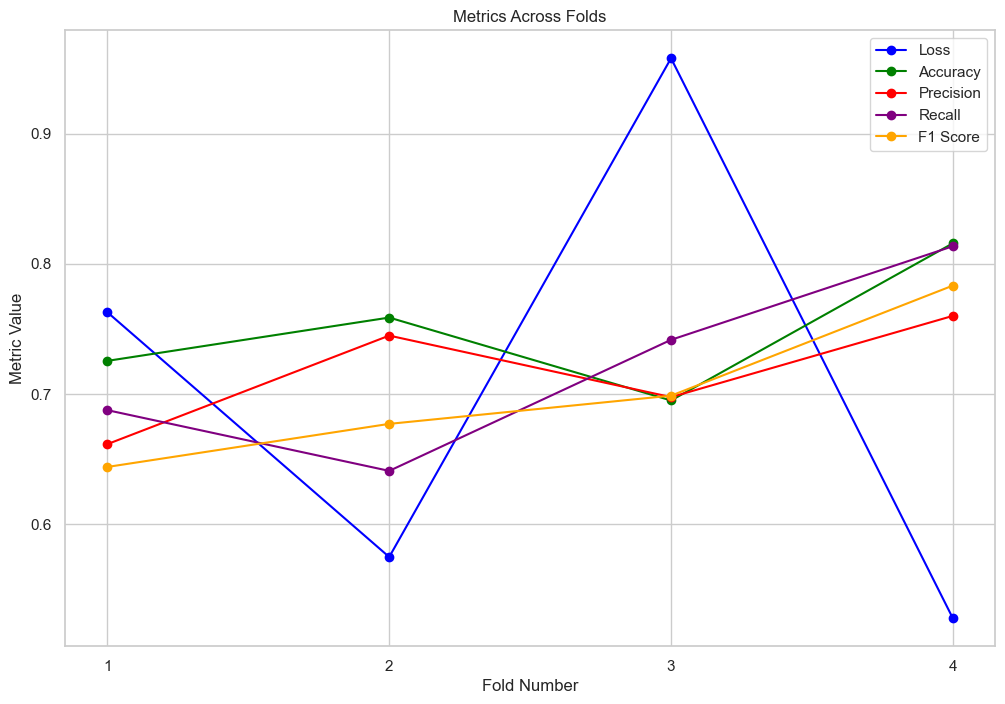

In [179]:
seed_5_folds_values = [unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1]

seed_5_training_acc_values = cv_training_acc_total

# Plotting all fold metrics|
seed_5_folds_plot = plot_all_metrics(unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1, "Folds", "Fold Number")

## Majority Voting on Total Entries per cat_id 

In [180]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 861, Predictions: 861, Actuals: 861, Gender: 861


In [181]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [182]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

# store for final evaluation 
all_majority_vote_accuracies.append(majority_vote_accuracy)

Overall Majority Vote Accuracy for cat_id: 0.79 (87/110)


In [183]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [184]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,000B,"[adult, adult, kitten, senior, adult, adult, a...",adult,adult,True
68,062A,"[adult, adult, adult, adult]",adult,adult,True
77,071A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
76,070A,"[adult, adult, adult, adult, adult]",adult,adult,True
75,069A,"[adult, adult]",adult,adult,True
74,068A,"[adult, adult, adult, senior, senior, adult, s...",adult,adult,True
73,067A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
72,066A,[adult],adult,adult,True
71,065A,"[senior, adult, adult, adult, adult, senior, s...",adult,adult,True
70,064A,"[adult, adult, adult]",adult,adult,True


In [185]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']

# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()

# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')

# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Count correct majority votes per class
correct_majority_votes_per_class = majority_with_actual.groupby('actual_age_group')['Majority_Correct'].sum()

print("Correct Majority Votes per Class:")
print(correct_majority_votes_per_class)

Correct Majority Votes per Class:
actual_age_group
adult     66
kitten    12
senior     9
Name: Majority_Correct, dtype: int64


In [186]:
# Calculate the total count and the number of correct predictions for each class
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    total_count=('Majority_Correct', 'size'),  # Total number of cases per class
    correct_count=('Majority_Correct', 'sum')  # Sum of correct predictions per class
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# store for final evaluation 
all_majority_vote_details.append(class_stats)

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
  actual_age_group  total_count  correct_count   accuracy
0            adult           73             66  90.410959
1           kitten           15             12  80.000000
2           senior           22              9  40.909091


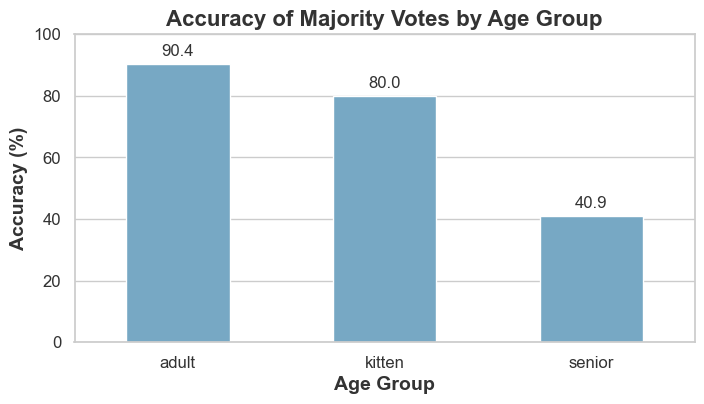

In [187]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')


## Detailed Class Statistics

In [188]:
# Calculate the total count and the number of correct predictions for each class
class_stats = full_results.groupby('actual_age_group').agg(
    total_count=('correct', 'size'),
    correct_count=('correct', 'sum')
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# store for final evaluation 
all_class_stats.append(class_stats)

# Log the detailed stats
print("Detailed Class Statistics:")
print(class_stats)

Detailed Class Statistics:
  actual_age_group  total_count  correct_count   accuracy
0            adult          574            481  83.797909
1           kitten          109             80  73.394495
2           senior          178             86  48.314607


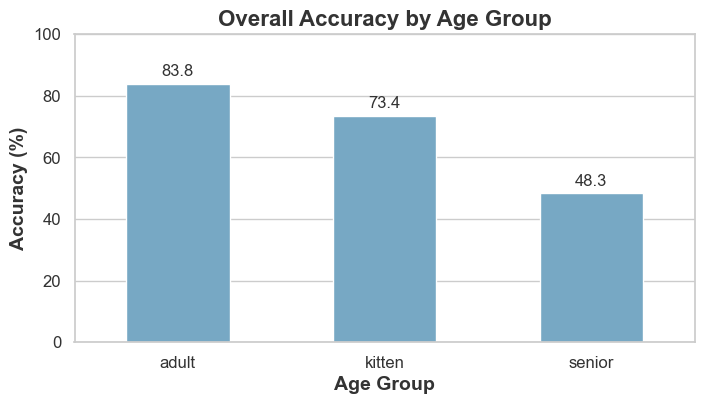

In [189]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [190]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

# store for final evaluation 
all_gender_stats.append(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F    213      168     78.87
1          M    362      284     78.45
2          X    286      195     68.18


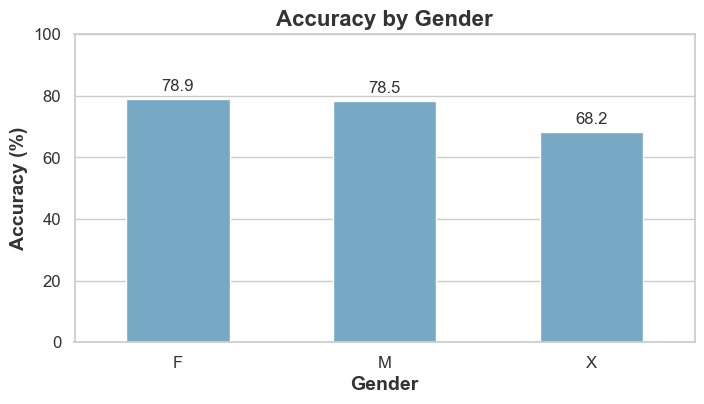

In [191]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

### Log current total CV Stats

In [192]:
print("Total Majority Vote Accuracy so far:", all_majority_vote_accuracies)
print("Total Class Statistics so far:\n", all_class_stats) 
print("Total Majority Vote Statistics so far:\n", all_majority_vote_details) 
print("Total Gender Accuracy so far:\n", all_gender_stats)

Total Majority Vote Accuracy so far: [0.7818181818181819, 0.7181818181818181, 0.7181818181818181, 0.8090909090909091, 0.7909090909090909]
Total Class Statistics so far:
 [  actual_age_group  total_count  correct_count   accuracy
0            adult          572            444  77.622378
1           kitten          109             94  86.238532
2           senior          178            113  63.483146,   actual_age_group  total_count  correct_count   accuracy
0            adult          554            454  81.949458
1           kitten          113             71  62.831858
2           senior          178             68  38.202247,   actual_age_group  total_count  correct_count   accuracy
0            adult          551            424  76.950998
1           kitten          113             91  80.530973
2           senior          178             79  44.382022,   actual_age_group  total_count  correct_count   accuracy
0            adult          552            450  81.521739
1           ki

# --------------

# Total Final Results & Analysis

In [193]:
# Count unique cat_id per age group 
unique_cats_per_age_group = dataframe.groupby('age_group')['cat_id'].nunique()

# Display the counts
print("Unique cat_id counts in original dataframe:", unique_cats_per_age_group)

Unique cat_id counts in original dataframe: age_group
adult     74
kitten    16
senior    22
Name: cat_id, dtype: int64


## Metrics

In [194]:
# Calculate overall metrics
overall_avg_loss = np.mean(all_losses)
overall_avg_acc = np.mean(all_accuracies)
overall_avg_precision = np.mean(all_precisions)
overall_avg_recall = np.mean(all_recalls)
overall_avg_f1 = np.mean(all_f1)

print("Overall Average Metrics:")
print("Loss:", overall_avg_loss)
print("Accuracy:", overall_avg_acc)
print("Precision:", overall_avg_precision)
print("Recall:", overall_avg_recall)
print("F1 Score:", overall_avg_f1)

Overall Average Metrics:
Loss: 0.8554133161902427
Accuracy: 0.7374880909919739
Precision: 0.7104241475022673
Recall: 0.7185249907573162
F1 Score: 0.6977392424185462


## Majority Votes

In [195]:
# Average of majority vote accuracies
average_majority_vote_accuracy = np.mean(all_majority_vote_accuracies)
print("Average Majority Vote Accuracy:", average_majority_vote_accuracy)

Average Majority Vote Accuracy: 0.7636363636363637


In [196]:
# Concatenate all class stats DataFrames and calculate the mean of accuracies
total_majority_vote_details = pd.concat(all_majority_vote_details)
average_majority_vote_details = total_majority_vote_details.groupby('actual_age_group').agg({
    'total_count': 'sum', 
    'correct_count': 'sum' 
}).reset_index()
average_majority_vote_details['accuracy'] = (average_majority_vote_details['correct_count'] / average_majority_vote_details['total_count']) * 100

print("Average Class Statistics:")
print(average_majority_vote_details)

Average Class Statistics:
  actual_age_group  total_count  correct_count   accuracy
0            adult          365            310  84.931507
1           kitten           75             58  77.333333
2           senior          110             52  47.272727


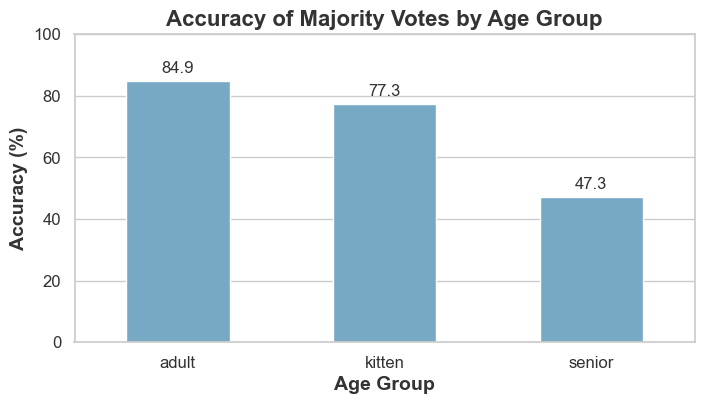

In [197]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(average_majority_vote_details, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')

## Detailed Class Statistics

In [198]:
# Concatenate all class stats DataFrames and calculate the mean of accuracies
total_class_stats = pd.concat(all_class_stats)
average_class_stats = total_class_stats.groupby('actual_age_group').agg({
    'total_count': 'sum',  
    'correct_count': 'sum' 
}).reset_index()
average_class_stats['accuracy'] = (average_class_stats['correct_count'] / average_class_stats['total_count']) * 100

print("Average Class Statistics:")
print(average_class_stats)

Average Class Statistics:
  actual_age_group  total_count  correct_count   accuracy
0            adult         2803           2253  80.378166
1           kitten          553            426  77.034358
2           senior          890            450  50.561798


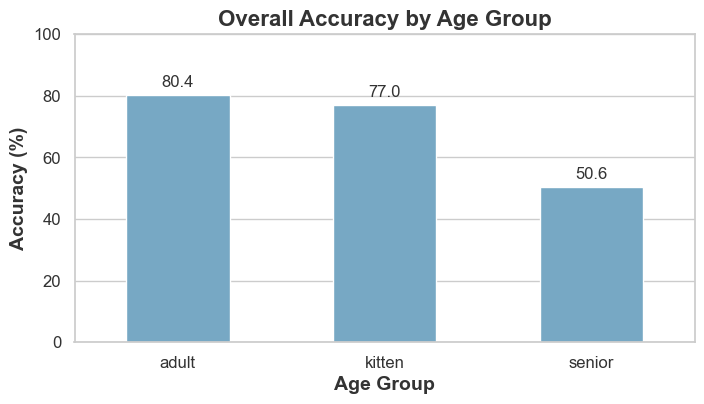

In [199]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(average_class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

In [200]:
# Concatenate all gender stats DataFrames and calculate the mean of accuracies
total_gender_stats = pd.concat(all_gender_stats)
average_gender_stats = total_gender_stats.groupby('all_gender').agg({
    'count': 'sum',  
    'correct': 'sum'  
}).reset_index()
average_gender_stats['accuracy'] = (average_gender_stats['correct'] / average_gender_stats['count']) * 100

print("Average Gender Accuracy:")
print(average_gender_stats)

Average Gender Accuracy:
  all_gender  count  correct   accuracy
0          F   1070      799  74.672897
1          M   1738     1311  75.431530
2          X   1438     1019  70.862309


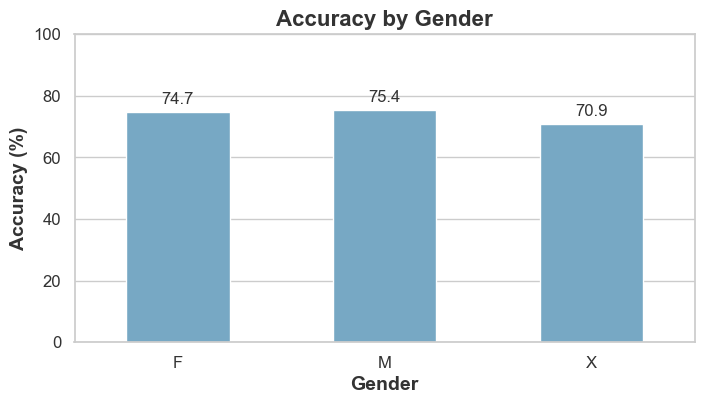

In [201]:
# Plot for Accuracy by Gender
styled_barplot(total_gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

# Visualisations

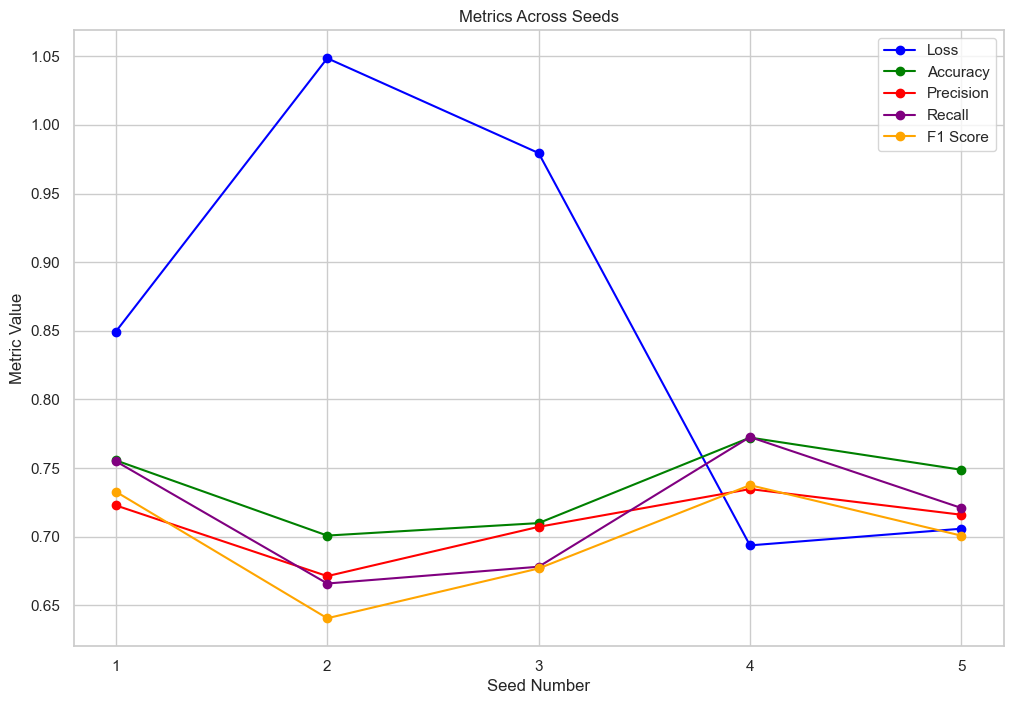

In [202]:
# Plotting all metrics
metrics_across_seeds = plot_all_metrics(average_fold_losses, average_fold_accuracies, average_fold_precisions, average_fold_recalls, average_fold_f1, "Seeds", "Seed Number")

## Display the seed folds results together

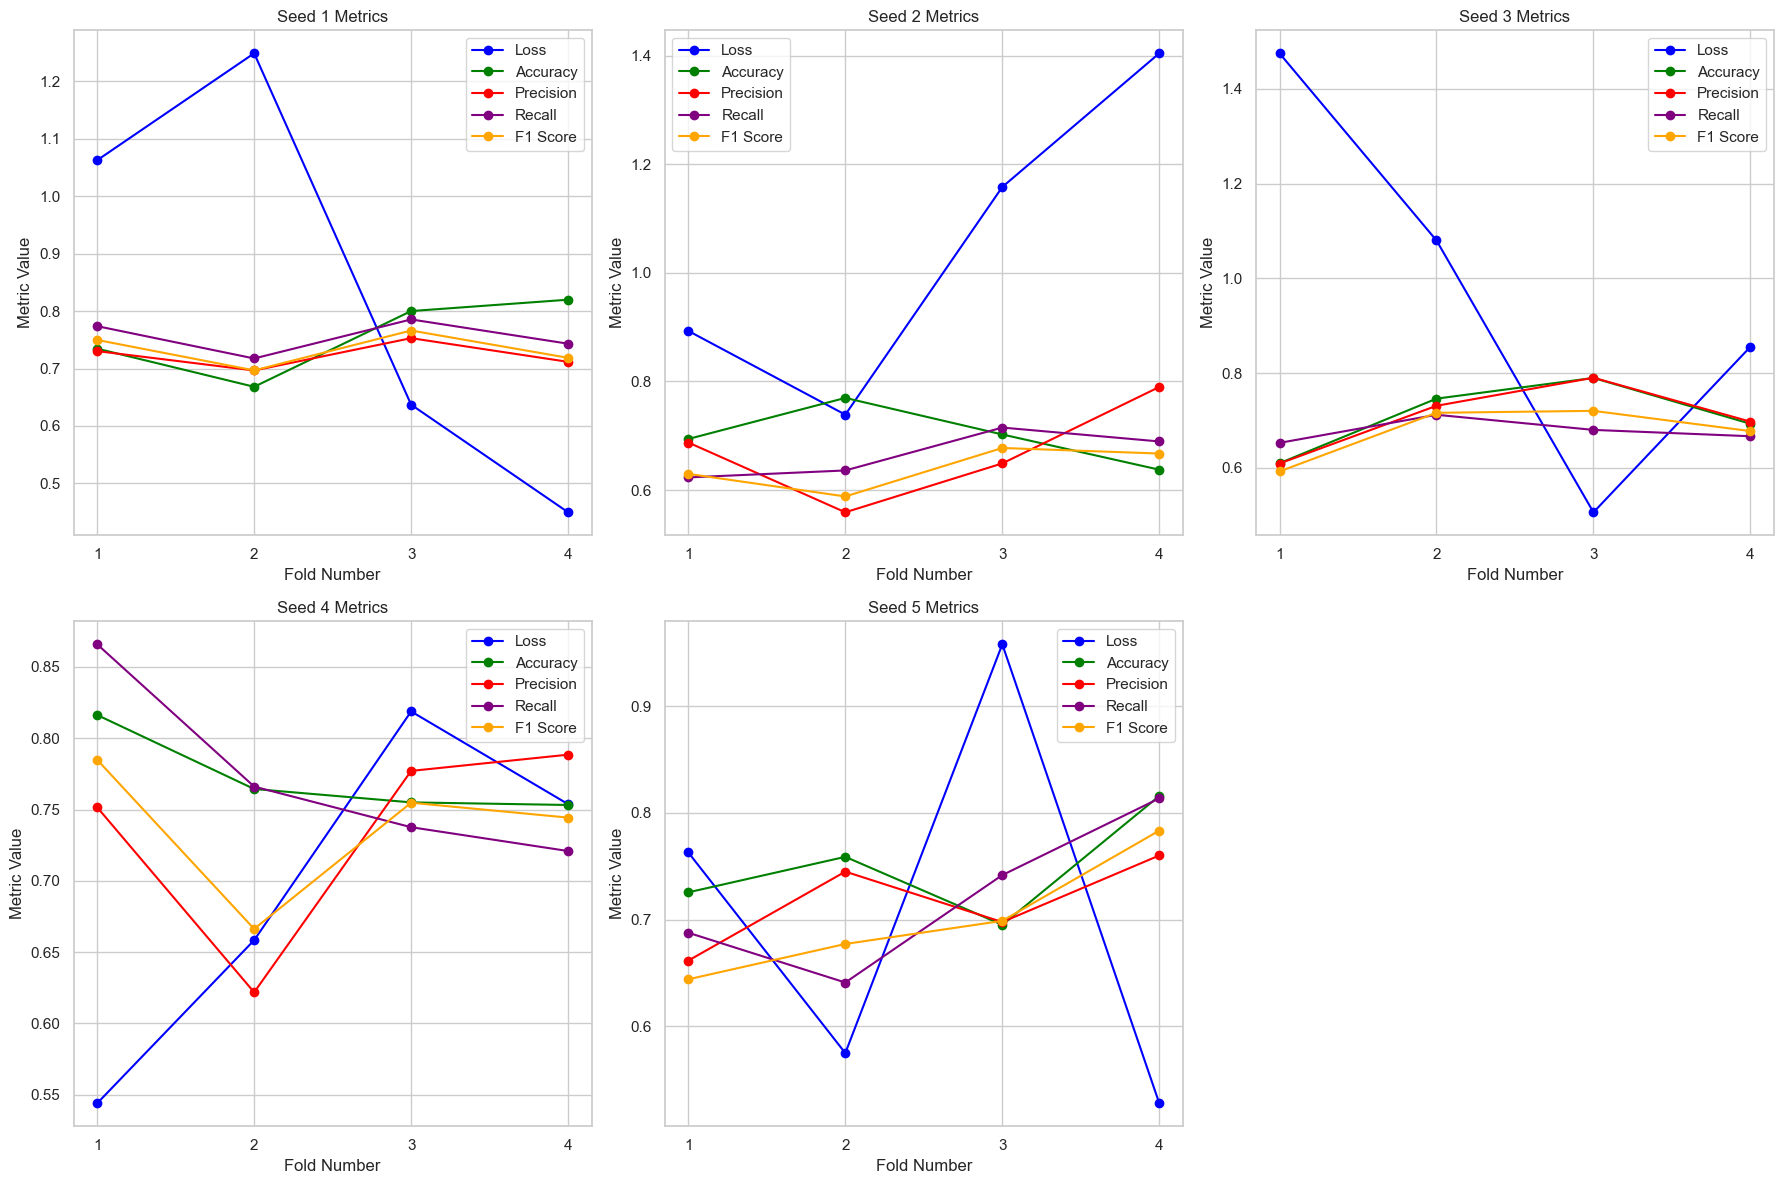

In [203]:
# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))  

# Flatten the axes array for easier indexing
axes = axes.flatten()

def plot_metrics_on_axes(ax, losses, accuracies, precisions, recalls, f1, title):
    ax.plot(range(1, len(losses)+1), losses, marker='o', color='blue', label='Loss')
    ax.plot(range(1, len(accuracies)+1), accuracies, marker='o', color='green', label='Accuracy')
    ax.plot(range(1, len(precisions)+1), precisions, marker='o', color='red', label='Precision')
    ax.plot(range(1, len(recalls)+1), recalls, marker='o', color='purple', label='Recall')
    ax.plot(range(1, len(f1)+1), f1, marker='o', color='orange', label='F1 Score')
    ax.set_xticks([1, 2, 3, 4])  # Set x-axis ticks to full integers
    ax.set_title(title)
    ax.set_xlabel('Fold Number')
    ax.set_ylabel('Metric Value')
    ax.legend()
    ax.grid(True)

# Plot onto each axes object
plot_metrics_on_axes(axes[0], *seed_1_folds_values, "Seed 1 Metrics")
plot_metrics_on_axes(axes[1], *seed_2_folds_values, "Seed 2 Metrics")
plot_metrics_on_axes(axes[2], *seed_3_folds_values, "Seed 3 Metrics")
plot_metrics_on_axes(axes[3], *seed_4_folds_values, "Seed 4 Metrics")
plot_metrics_on_axes(axes[4], *seed_5_folds_values, "Seed 5 Metrics")

# Hide the unused subplot 
for ax in axes[5:]:
    ax.set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()

# Statistics

### Standard Deviation

In [204]:
# Calculate the standard deviation for each metric
std_loss = np.std(all_losses)
std_accuracy = np.std(all_accuracies)
std_precision = np.std(all_precisions)
std_recall = np.std(all_recalls)
std_f1 = np.std(all_f1)

print("Standard Deviations:")
print(f"Loss: {std_loss}")
print(f"Accuracy: {std_accuracy}")
print(f"Precision: {std_precision}")
print(f"Recall: {std_recall}")
print(f"F1 Score: {std_f1}")

Standard Deviations:
Loss: 0.2938623632935094
Accuracy: 0.05775293553576771
Precision: 0.06301375677648675
Recall: 0.06091334446784346
F1 Score: 0.05600741772315176


### Interquartile Range

In [205]:
# Calculate the interquartile range for each metric
iqr_loss = np.percentile(all_losses, 75) - np.percentile(all_losses, 25)
iqr_accuracy = np.percentile(all_accuracies, 75) - np.percentile(all_accuracies, 25)
iqr_precision = np.percentile(all_precisions, 75) - np.percentile(all_precisions, 25)
iqr_recall = np.percentile(all_recalls, 75) - np.percentile(all_recalls, 25)
iqr_f1 = np.percentile(all_f1, 75) - np.percentile(all_f1, 25)

print("Interquartile Ranges:")
print(f"Loss: {iqr_loss}")
print(f"Accuracy: {iqr_accuracy}")
print(f"Precision: {iqr_precision}")
print(f"Recall: {iqr_recall}")
print(f"F1 Score: {iqr_f1}")


Interquartile Ranges:
Loss: 0.44549690186977386
Accuracy: 0.07993103563785553
Precision: 0.07362369374738353
Recall: 0.07187527920859771
F1 Score: 0.0787243876320538


### Variation

In [206]:
# Calculate the variation for each metric
var_loss = np.var(all_losses)
var_accuracy = np.var(all_accuracies)
var_precision = np.var(all_precisions)
var_recall = np.var(all_recalls)
var_f1 = np.var(all_f1)

print("Variations:")
print(f"Loss: {var_loss}")
print(f"Accuracy: {var_accuracy}")
print(f"Precision: {var_precision}")
print(f"Recall: {var_recall}")
print(f"F1 Score: {var_f1}")

Variations:
Loss: 0.0863550885604465
Accuracy: 0.003335401562998541
Precision: 0.003970733543086231
Recall: 0.0037104355342581553
F1 Score: 0.0031368308400156137


### Levene tests for variation significance between seeds

#### Levene across seeds for LOSS

In [207]:
# Levene across seeds for LOSS
stat_val, p_val = levene(seed_1_folds_values[0], seed_2_folds_values[0], seed_3_folds_values[0], seed_4_folds_values[0], seed_5_folds_values[0])
print(f'levene test statistic: {stat_val:.2f}, P-value: {p_val:.3f}')

levene test statistic: 2.02, P-value: 0.143


#### Levene across seeds for ACCURACY

In [208]:
# Levene across seeds for ACCURACY
stat_val, p_val = levene(seed_1_folds_values[1], seed_2_folds_values[1], seed_3_folds_values[1], seed_4_folds_values[1], seed_5_folds_values[1])
print(f'levene test statistic: {stat_val:.2f}, P-value: {p_val:.3f}')

levene test statistic: 0.98, P-value: 0.448


#### Levene across seeds for PRECISION

In [209]:
# Levene across seeds for PRECISION
stat_val, p_val = levene(seed_1_folds_values[2], seed_2_folds_values[2], seed_3_folds_values[2], seed_4_folds_values[2], seed_5_folds_values[2])
print(f'levene test statistic: {stat_val:.2f}, P-value: {p_val:.3f}')

levene test statistic: 0.71, P-value: 0.598


#### Levene across seeds for RECALL

In [210]:
# Levene across seeds for RECALL
stat_val, p_val = levene(seed_1_folds_values[3], seed_2_folds_values[3], seed_3_folds_values[3], seed_4_folds_values[3], seed_5_folds_values[3])
print(f'levene test statistic: {stat_val:.2f}, P-value: {p_val:.3f}')

levene test statistic: 1.14, P-value: 0.377


#### Levene across seeds for F1

In [211]:
# Levene across seeds for F1
stat_val, p_val = levene(seed_1_folds_values[4], seed_2_folds_values[4], seed_3_folds_values[4], seed_4_folds_values[4], seed_5_folds_values[4])
print(f'levene test statistic: {stat_val:.2f}, P-value: {p_val:.3f}')

levene test statistic: 0.18, P-value: 0.947


## Print out measurements for future further analysis (without rerunning notebook)

In [212]:
seed_1_folds_values

[[1.06254243850708, 1.2487205266952515, 0.637008786201477, 0.4496917426586151],
 [0.7345678806304932, 0.668181836605072, 0.800000011920929, 0.819767415523529],
 [0.7302867383512545,
  0.696592372695002,
  0.752830610816191,
  0.7115731573157316],
 [0.7737099535338713,
  0.7174679487179487,
  0.7854227634601467,
  0.7431818181818182],
 [0.7497016197783463,
  0.6967687690015416,
  0.7661298347240962,
  0.7185944296417753]]

In [213]:
seed_2_folds_values

[[0.8930092453956604,
  0.7387664914131165,
  1.1580663919448853,
  1.404289960861206],
 [0.6940298676490784,
  0.7696335315704346,
  0.7023255825042725,
  0.6374269127845764],
 [0.6875, 0.5589834515366431, 0.649017649017649, 0.7897756911841419],
 [0.6232183626875408,
  0.6360471070148489,
  0.7150160168633505,
  0.6894650732678902],
 [0.6297404087981285,
  0.5881722058192647,
  0.677437641723356,
  0.667187754437388]]

In [214]:
seed_3_folds_values

[[1.475339651107788,
  1.0802323818206787,
  0.5064430832862854,
  0.855906069278717],
 [0.6100917458534241,
  0.7463414669036865,
  0.7900552749633789,
  0.6932772994041443],
 [0.6093984962406015,
  0.7312445707968096,
  0.7904687904687905,
  0.6977539788784769],
 [0.6529870129870129,
  0.7122842525439927,
  0.6803874092009686,
  0.6669920470969255],
 [0.5927175812315453,
  0.7164766376033982,
  0.7205751633986929,
  0.6778206938324582]]

In [215]:
seed_4_folds_values

[[0.5439038872718811,
  0.6583408117294312,
  0.8188357949256897,
  0.7537686824798584],
 [0.8163265585899353,
  0.7644230723381042,
  0.7550200819969177,
  0.7531914710998535],
 [0.7515634446327515,
  0.6217713365539453,
  0.7770975056689342,
  0.7884877027734171],
 [0.8659356725146199,
  0.7661099369887676,
  0.7376010233153091,
  0.7208791208791209],
 [0.7849062702003878,
  0.6662548507167182,
  0.754777647884031,
  0.7443380149262503]]

In [216]:
seed_5_folds_values

[[0.762823224067688,
  0.5748457312583923,
  0.9579364061355591,
  0.5277950167655945],
 [0.7254902124404907,
  0.7587548494338989,
  0.695067286491394,
  0.8157894611358643],
 [0.6615410052910052,
  0.744902345755056,
  0.6976501542369805,
  0.7600439478319663],
 [0.6876289419392867,
  0.6409837253452748,
  0.7416500774165008,
  0.8135315511911257],
 [0.6440151742038535,
  0.6771015146729239,
  0.6987561879906377,
  0.7833124477861318]]

## Training Accuracy Analysis

In [217]:
all_best_training_acc

[0.9734848737716675,
 0.9816103577613831,
 0.968539297580719,
 0.9660611748695374,
 0.9752747416496277,
 0.9863078594207764,
 0.9667328596115112,
 0.974321722984314,
 0.9798029661178589,
 0.9904714226722717,
 0.9625719785690308,
 0.9785788655281067,
 0.971222996711731,
 0.9676952958106995,
 0.9815818071365356,
 0.972515881061554,
 0.9621350169181824,
 0.9647812247276306,
 0.9790173768997192,
 0.9700811505317688]

In [218]:
total_training_acc

[[0.5923295617103577,
  0.6889204382896423,
  0.7272727489471436,
  0.7372159361839294,
  0.7698863744735718,
  0.7604166865348816,
  0.7869318127632141,
  0.78125,
  0.8053977489471436,
  0.7959280014038086,
  0.8030303120613098,
  0.8158143758773804,
  0.8134469985961914,
  0.8357007503509521,
  0.8309659361839294,
  0.8357007503509521,
  0.8451704382896423,
  0.8499053120613098,
  0.8560606241226196,
  0.8546401262283325,
  0.8527461886405945,
  0.857481062412262,
  0.8432765007019043,
  0.859375,
  0.8660038113594055,
  0.8735795617103577,
  0.8754734992980957,
  0.8669507503509521,
  0.8678977489471436,
  0.8674242496490479,
  0.8778409361839294,
  0.8825757503509521,
  0.8650568127632141,
  0.8821022510528564,
  0.8754734992980957,
  0.8825757503509521,
  0.8858901262283325,
  0.8967803120613098,
  0.8944128751754761,
  0.892518937587738,
  0.8934659361839294,
  0.9048295617103577,
  0.8944128751754761,
  0.8977272510528564,
  0.8929924368858337,
  0.8996211886405945,
  0.9029356

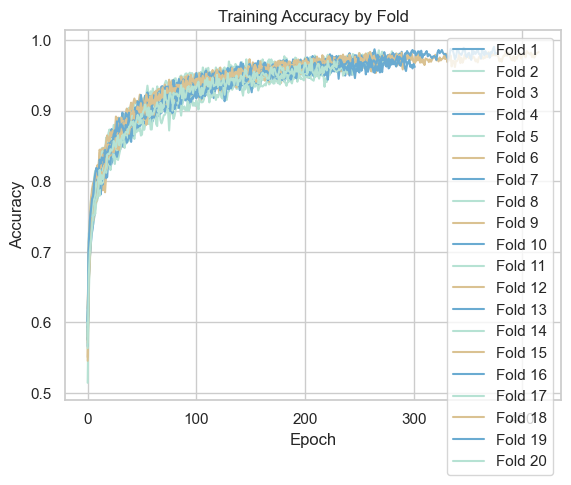

In [219]:
# Plot accuracy histories for all folds
for i, fold_accuracy in enumerate(total_training_acc):
    plt.plot(fold_accuracy, label=f'Fold {i+1}')

plt.title('Training Accuracy by Fold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [220]:
# running time including analysis
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 565.9217131137848 seconds
